## Analysis code for 'Are colour experiences the same across the visual field?'
### Code for calculating BFs for analysis in progress at QIST
Written by Ariel Zeleznikow-Johnston, 2022
ariel.zeleznikow-johnston@monash.edu  
Github link to experiment: https://github.com/ArielZJ/SimilarityColorProject-MultiplePatches  
Github link to this analysis code: https://github.com/ArielZJ/Precision-Phenomenology-Data-Analysis

### Initialisations

In [1]:
#filename = "data/pilotcompiled.csv"
#savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later

In [72]:
# various parameters
stimuli_number = 9
response_type_list = c('during')
trial_types = c('during')
response_names = c('During')
catch_trial_number = 10 # what it's set at at the moment, arbitrary
condition_number = 4
experiment_number = 4
max.DSR = 7
min.DSR = 0

In [3]:
trace_cutoff = 2 # mean dissimilarity for physically identical colours must be below this
antitrace_cutoff = 3.5 # mean dissimilarity accepted for maximally physically different colours must be above this
rt_cutoff = 0 # mean reaction times must be above this
score_cutoff=0.77

In [4]:
exclude_noncompliant = FALSE

In [5]:
# colors for the labels
# changed for this mixed version
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9',"#00A9FF",'#0000FF','#AA00FF',"#FF00AA")
abcolors <- sort(colors)

eccens.colors <- c(
    'Central #FF0000',
    'Central #FFAA00',
    'Central #AAFF00',
    'Central #00FF00',
    'Central #00FFA9',
    "Central #00A9FF",
    'Central #0000FF',
    'Central #AA00FF',
    "Central #FF00AA",
    'Peripheral #FF0000',
    'Peripheral #FFAA00',
    'Peripheral #AAFF00',
    'Peripheral #00FF00',
    'Peripheral #00FFA9',
    "Peripheral #00A9FF",
    'Peripheral #0000FF',
    'Peripheral #AA00FF',
    "Peripheral #FF00AA")

inverted.colors <-  c('#FF0000','#FF00AA','#AA00FF','#0000FF','#00A9FF','#00FFA9','#00FF00','#AAFF00','#FFAA00')

### Initialisations

In [6]:
# live dangerously, get rid of pesky warnings
oldw <- getOption("warn")
options(warn = -1)

In [7]:
#install.packages("car")

In [8]:
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(MASS)
library(Matrix)
library(reshape2)
library(ape) # stats
library(vegan) # stats
library(RColorBrewer)
library(cocor)
library(DescTools)
library(reshape2)
library(grid)
library(ggplotify)
#library(fclust)
library(plot.matrix)
#library(gtools)
library(stringi)
#library(Bolstad)
#library(olsrr) # for checking violation of regression assumptions
library(lmtest) # for likelihood ratio test
library(car) # for logistic transformation
#library(betareg) # beta regressions
#library(coin) # wilcox power analyses
#library(rstatix) # power analyses
#library(boot)
library(cowplot) # for making figures
#library(readr) # for making figures


Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select



Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack



Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths


Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading requi

In [10]:
#install.packages("rstanarm")
#install.packages("bridgesampling")
#install.packages("bayestestR")

In [11]:
# getting bayesbr to do the bayesian analysis
#library(bayesbr)
library(BayesFactor)
#library(brms)
library(rstanarm)
library(bridgesampling)
library(bayestestR)
#library(see)
#library(bayesplot)

In [12]:
library(betareg)

### Load the data

In [26]:
files = list.files(path=paste(getwd(),'/data',sep=''),pattern="*.iqdat")
#print(files)
files <- paste(getwd(),'/data/',files,sep='')
#print(files)
#test <- read.csv(files[1], sep='\t')
#print(head(test))
data = sapply(files, read.csv, sep='\t', simplify=FALSE) %>% bind_rows(.id = "id")

### Functions we're going to use to do the analysis later

#### Miscellaneous

In [249]:
# check our N 
get_n <- function(datadf,print=TRUE){
    n <- length(unique(datadf$subject))
    if(print){
        print(paste("There are",n,"unique subjects"))
    }
    return(n)
}

In [28]:
get_n.grouped <- function(datadf){
    size <- sort(unique(datadf$stimulus_size))
    scale <- sort(unique(datadf$peripheral_scale))
    for(stim in (size)){
        for(mag in (scale)){
            data <- (subset(datadf,stimulus_size == stim & peripheral_scale == mag))
            n <- length(unique(data$subject))
            print(paste('Magnification',mag,'Size',stim,' - N =',n))
        }
    }
}

In [29]:
# get plot eccentricity labels
ploteccen <- function(datadf){
    if(datadf$Circle_1[1] == -1){
            label1 = 'Central'
        } else {
            label1 = 'Peripheral'
        }
        if(datadf$Circle_2[1] == -1){
            label2 = 'Central'
        } else {
            label2 = 'Peripheral'
        }
    return(c(label1,label2))
}

e2l <- function(eccentricity){
    if(eccentricity == -1){
        return('Central')
    } else {
        return('Peripheral')
    }
}

l2e <- function(eccentricity){
    if(eccentricity == 'Central'){
        return(-1)
    } else {
        return(1)
    }
}

In [30]:
get.submat <- function(mat,submat){
    if(submat == 'CC'){
        out.mat <- mat[1:9,1:9]
    } else if (submat == 'CP'){
        out.mat <- mat[1:9,10:18]
    } else if (submat == 'PP'){
        out.mat <- mat[10:18,10:18]
    }
    return(out.mat)
}

#### Dissimilarity Matrices

In [31]:
# obtain dissimilarity matrices with particular eccentricity values from dataframes
# doesn't care whether this comes from individual subjects or whole populations
dissimdata <- function(datadf, colors, eccentricity1, eccentricity2){
    # select only the eccentricities we want to keep, e.g. (Central, Central)
    datatemp = subset(datadf, Circle_1 == eccentricity1)
    datatemp = subset(datatemp, Circle_2 == eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [32]:
# plot a dissimilarity matrix
dissimplot <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = similarity)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [33]:
# making a matrix symmetric. Borrowed from dclone: https://rdrr.io/github/datacloning/dclone/src/R/make.symmetric.R
make.symmetric <-function(x)
{
    if (dim(x)[1] != dim(x)[2])
        stop("'x' is not a square matrix")
    rval <- t(x)
    m <- (x[lower.tri(x)] + rval[lower.tri(rval)]) / 2
    rval[lower.tri(rval)] <- m
    rval <- t(rval)
    rval[lower.tri(rval)] <- m
    rval
}

In [34]:
# obtain dissimilarity dataframe that corresponds to all of a subject's judgements
# adds the columns color1.eccen1 and color2.eccen2
dissimdata.subject <- function(datadf, diagnose=FALSE){
        
    # first, get a full label for each trial
    datadf <- subset(datadf, trial_type != 'catch') # get rid of catch trials
    
    datadf$Circle_1[datadf$Circle_1 == -1] <- 'Central'
    datadf$Circle_2[datadf$Circle_2 == -1] <- 'Central'
    datadf$Circle_1[datadf$Circle_1 == 1] <- 'Peripheral'
    datadf$Circle_2[datadf$Circle_2 == 1] <- 'Peripheral'
    datadf$color1.eccen1 <- paste(datadf$Circle_1,datadf$Color_1,sep=' ')
    datadf$color2.eccen2 <- paste(datadf$Circle_2,datadf$Color_2,sep=' ')
    datadf$color1 <- datadf$Color_1
    datadf$color2 <- datadf$Color_2

    
    # refactor the levels so they can be plotted properly later if need be
       datadf$color1.eccen1 <- with(datadf, factor(color1.eccen1, levels = eccens.colors))
       datadf$color2.eccen2 <- with(datadf, factor(color2.eccen2, levels = eccens.colors))
    if(diagnose){print(paste("Subject trial number:", nrow(datadf)))}
     
    
    #print(datadf$color1.eccen1)
    return(datadf)
}

In [35]:
# convert a df to a group of subject matrices
dissimgroup2matlist <- function(df,sym=TRUE){
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    mat.list <- list()
    k = 1
    for(ID in subjectlist){
        subjectdf <- subset(df, subject == ID)
        subject.mat <- color.eccen.mat(dissimdata.subject(subjectdf), output='matrix',
                                       symmeterise=sym,sym.CP=sym)
        mat.list[[k]] <- subject.mat
        k = k + 1
    }
    return(mat.list)
} 

In [36]:
# convert a group of matrices to a group mean matrix
group.mat.mean <- function(mat.list){
    # average the matrices
    mat.average <- Reduce('+',mat.list)/length(mat.list)
    return(mat.average)
}
   

In [37]:
# convert a group of matrices to a group median matrix
group.mat.median <- function(mat.list){
    
    out.v <- vector()
    
    n.vals <-length(c(mat.list[[1]]))
    n.subjects <- length(mat.list)
    for(i in 1:n.vals){
        vals <- vector()
        for(j in 1:n.subjects){
            v <- c(mat.list[[j]])[i]
            vals <- c(vals,v)
        }
        out.v[i] <- median(vals)
    }
    
    out.mat <- matrix(out.v,nrow(mat.list[[1]]),ncol(mat.list[[1]]))
    
    colnames(out.mat) <- colnames(mat.list[[1]])
    rownames(out.mat) <- rownames(mat.list[[1]])
    
    return(out.mat)
}

In [38]:
# convert a full matrix to a variance matrix
full2var <- function(mat){
    # initialise the output variance matrix
    var.mat <- matrix(,nrow(mat)/2,ncol(mat)/2)
    
    # fill the output variance matrix
    for(row in 1:(nrow(mat)/2)){
        for(column in 1:(ncol(mat)/2)){

            CC <- mat[row,column]
            CP <- mat[row + nrow(var.mat), column]
            PP <- mat[row + nrow(var.mat), column + nrow(var.mat)]
            
            val <- var(c(CC,CP,PP))
            var.mat[row,column] <- val
        }
    }
    colnames(var.mat) <- colors
    rownames(var.mat) <- colors
    # return
    return(var.mat)
}

In [39]:
# convert a group of full color matrices to a group of within-subject mean color-pair variance matrices
full2var.mats <- function(mat.list){
    var.list <- list()
    for(mat in 1:length(mat.list)){
        var.list[[mat]] <- full2var(mat.list[[mat]])
    }
    return(var.list)
}

In [40]:
# make a dissimilarity plot for a group of subjects
group.dissim <- function(df,sym=FALSE){
    mats <- dissimgroup2matlist(df,sym=sym)
    avg.mat <- group.mat.mean(mats)
    
    data <- melt(avg.mat)
    colnames(data) <- c('color1.eccen1','color2.eccen2','similarity')
    return(data)
    
    
}




In [41]:
# make a median variance plot for a group of subjects
group.dissim.var <- function(df){
    mats <- dissimgroup2matlist(df)
    mats.var <- full2var.mats(mats)
    avg.mat <- group.mat.median(mats.var)
    
    data <- melt(avg.mat)
    colnames(data) <- c('color1.eccen1','color2.eccen2','similarity')
    return(data)
    
    
}


In [42]:
# label the rows with the two colours independent of arbitrary ordering
dissimplot.full <- function(datadf, mode='standard',
                            rotation=90,dependent='dissimilarity',
                           reverse=TRUE,
                           label='',info='TRUE'){
        
    if(dependent=='RT'){
        #datadf$similarity <- log10(datadf$similarity)
    }
    
    plot <- ggplot(datadf, aes(x = color1.eccen1, y = color2.eccen2)) 
    
    if(mode=='standard'){
        color.list <- c(colors,colors)
    } else if (mode=='inversion'){
        color.list <- c(colors, inverted.colors)
    } else if (mode == 'rotation'){
        color.list <- c(colors, rotate.vec(colors,rotation))
    }
    
    
    
    # dissimilarity plot
    if(dependent=='dissimilarity'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"),
                                    limits=c(0,7),
                                    breaks=c(0,1,2,3,4,5,6,7),
                                    na.value='darkblue') +
                guides(fill=guide_legend(title="Dissimilarity"))
    }
    # reaction time plot
    if(dependent=='RT'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"), trans = "log",
                                    #limits=c(1000,1600),
                                    #limits=c(2.9,3.3),
                                    #breaks=c(2.9,3,3.146,3.255,3.3),
                                     limits = c(800,2000),
                                    breaks=c(800,1000,1400,1800),
                                    labels=c(800,1000,1400,1800)
                                    ) +
                guides(fill=guide_legend(title="RT (log)"))
    }
    # reverse plot
    if(reverse){
        plot <- plot + scale_y_discrete(limits = rev(levels(datadf$y)))
    }
    
    if(info){ # labels on
        plot <- plot + theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      plot.title = element_text(hjust = 0.5)) +
                    ggtitle(label) +
                    #xlab("SCREEN FIXED                    SCREEN MOVE") + 
                    #ylab("RETINA FIXED                    RETINA MOVE") 
                    xlab("CENTRAL                          PERIPHERAL") + 
                    ylab("CENTRAL                          PERIPHERAL")
    } else {  # labels off
        plot <- plot + theme(axis.text.x = element_blank(),
                        axis.text.y = element_blank(),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_blank(), legend.position='none')
    } 
    
    return(plot)
    
}

In [43]:
# convert a dataframe to a matrix. Only works on submatrices
df2mat.full <- function(datadf,eccentricity1=l2e('Central'),eccentricity2=l2e('Central'),sym=FALSE){
 
    # select only the eccentricities we want to keep, e.g. (Central, Central)
    datadf <- subset(datadf, Circle_1 == eccentricity1 & Circle_2 == eccentricity2)

    # aggregate over the remaining columns of interest
    datadf <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    datadf$Color_1 <- datadf$Group.1
    datadf$Color_2 <- datadf$Group.2

    datadf = subset(datadf, select = c("Color_1","Color_2","similarity"))  # get rid of unnecessary columns
    datadf <- spread(datadf, Color_1, similarity)
    
    # convert the dataframe to a matrix
    datamatrix <- data.matrix(datadf)
    datamatrix <- datamatrix[,-1] # get rid of the labels in the first column, it messes up the code
    if(sym){
        datamatrix <- make.symmetric(datamatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    }
    rownames(datamatrix) <- colnames(datamatrix)
    
    # sort the matrix
    datamatrix <- datamatrix[, sort(colnames(datamatrix))][sort(rownames(datamatrix)),]
    
    return(datamatrix)
    
}

In [44]:
# variance plot for matrices
variance.plot <- function(mat,
                         col1='blue',col2='yellow',na.col='green',
                                  legend.title='Variance',
                                  xlabel='',ylabel='',
                                  low.lim=0,up.lim=10){
    if(ncol(mat)<10){
        color.list <- colors
    } else {
        color.list <- c(colors,colors)
    }
    longData <- melt(mat)
    
    
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(legend.title,colours = c(col1,col2),
                         limits = c(low.lim,up.lim), 
                         breaks=c(low.lim,up.lim),
                        na.value=na.col) + 
    theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))

    return(plot)
}
    

In [45]:
# convert a dataframe to a matrix v2, with some added functionality and without automatic
# symmeterisation
color.eccen.mat <- function(df,output='DF',mode='identity',rotation=90,plot=FALSE,dependent='dissimilarity',
                           symmeterise=TRUE,sym.CP=TRUE,shuffle=FALSE,
                            diagnose=FALSE){
    library('plot.matrix')
    if(dependent=='RT'){
        df$similarity <- df$response_time
    }
    data <- subset(df, select = c(color1.eccen1, color2.eccen2, similarity))
    if(diagnose){
        print(data)
    }
    #print(head(data)) # testing
    data <- spread(data, color1.eccen1, similarity)
    #print(data) # testing
    row.names <- data$color2.eccen2
    data.mat <- data.matrix(data)
    rownames(data.mat) <- row.names
    data.mat <- data.mat[,-1] # get rid of the redundant first column
    
    # duplicate missing values
    #print(plot(data.mat))
    if(symmeterise){
        if(sym.CP){ # symmeterise over CP/PC
            CP <- data.mat[10:18,1:9]
            CP.t <- t(CP)
            data.mat[10:18,1:9] <- group.mat.mean(list(CP,CP.t))
            data.mat[1:9,10:18] <- t(data.mat[10:18,1:9])
        }
        # symmeterise the full matrix
        data.mat.t <- t(data.mat)
        data.mat <- group.mat.mean(list(data.mat,data.mat.t))
    }
    # shuffle CP & PP for plotting purposes if desired
    if(shuffle){
        data.mat[10:18,1:9] <- matrix(sample(data.mat[10:18,1:9]),nrow=9)
        data.mat[1:9,10:18] <- matrix(sample(data.mat[1:9,10:18]),nrow=9)
        data.mat[10:18,10:18] <- matrix(sample(data.mat[10:18,10:18]),nrow=9)
    }
    # perform a label swap
    Peripheral.labels <- c(10:18)
    if(mode == 'random'){
        swap.vec <- sample(Peripheral.labels) # pick a random ordering of the Peripheral labels
    } else if (mode == 'rotate'){
        swap.vec <- rotate.vec(Peripheral.labels,rotation=rotation)
    } else if (mode == 'invert'){
        swap.vec <- match(inverted.colors,colors) + 9
    }
    if(mode != 'identity'){ # do the swap
        data.mat[10:18,] <- data.mat[swap.vec, ] # reorder the rows
        data.mat[,10:18] <- data.mat[, swap.vec] # reorder the columns
    }
        
    
    # plot the data
    if(plot){
        plot(data.mat, col=gray.colors(8, start=0, end=1, gamma=0.75, rev=TRUE),
         xlab = 'Fovea                                      Periphery',
        ylab = 'Fovea                                      Periphery')
    }
    
    # choose output type
    if(output == 'DF'){
        data <- as.data.frame(as.table(data.mat))
        colnames(data) <- c("color1.eccen1","color2.eccen2","similarity")
        return(data)
    } else if (output == 'matrix'){
        return(data.mat)
    }
}

In [46]:
# calculate the mean value of the trace of a matrix, aka 'normalised trace'
norm.trace <- function(mat){
    val <- sum(diag(mat))/nrow(mat)
    return(val)
}

# calculate the mean of the other values in the matrix
non.trace <- function(mat){
    other_sum <- sum(mat) - sum(diag(mat))
    val <- other_sum/(length(mat)-length(diag(mat)))
    return(val)
}

# calculate the difference between a matrix's normalised trace and the mean of the other values in the matrix
norm.trace.difference <- function(mat){
    val <- non.trace(mat) - norm.trace(mat)
    return(val)
}

# calculate trace average, small values presumably indicate subjects not just saying everything is completely dissimilar
# will also need a complementary method to deal with them saying everything is the same? Might be an inappropriate
# a-priori imposition though, I probably can't tell people how similar different colours should be...
trace_avg <- function(datadf,mode='trace'){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(datadf, l2e('Central'), l2e('Central'))
    fpmatrix <- df2mat.full(datadf, l2e('Central'), l2e('Peripheral'))
    pmatrix <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    if(mode=='trace'){ # just calculate the normalised trace
        cc <- norm.trace(fmatrix)
        cp <- norm.trace(fpmatrix)
        pp <- norm.trace(pmatrix)
    } else if (mode=='difference'){ # calculate the difference between the mean of the rest of the matrix and the normalised trace
        # note, these are unsymmeterised matrices so the analysis is on the raw values
        cc <- norm.trace.difference(fmatrix)
        cp <- norm.trace.difference(fpmatrix)
        pp <- norm.trace.difference(pmatrix)
    } else if (mode=='non-trace'){ # calculate the mean value for everything except the normalised trace
        cc <- non.trace(fmatrix)
        cp <- non.trace(fpmatrix)
        pp <- non.trace(pmatrix)
    }
    
    return(list(cc,cp,pp))
}

# used for testing whether pilot data subjects needed to have their data inverted
norm.trace.cc <- function(datadf){
    fmatrix <- df2mat.full(datadf, l2e('Central'), l2e('Central'))
    cc <- sum(diag(fmatrix))/nrow(fmatrix)
    return(cc)
}

In [150]:
# obtains a dataframe of traces for subjects
# type can be 'trace' or 'difference'
trace_obtainer <- function(datadf,type="trace"){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    tracedf <- data.frame(subject=character(),
                          fftrace=double(),
                          fptrace=double(),
                          pptrace=double(),
                         stim_size=double(),
                         magnification=double()) # initialise an output df for the traces
    for (ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        magnification_list <- sort(unique(datadf$peripheral_scale))
        size_list <- sort(unique(datadf$stimulus_size))
        for (stimulus in size_list){
            for (scale in magnification_list){
                tempdf2 <- subset(tempdf, peripheral_scale == scale & stimulus_size == stimulus)
                subject_trace <- trace_avg(tempdf2,mode=type)
                stim <- unique(tempdf2$stimulus_size)[1]
                mag <- unique(tempdf2$peripheral_scale)[1]
                row_df <- data.frame(ID, as.numeric(subject_trace[1]),
                                     as.numeric(subject_trace[2]),
                                     as.numeric(subject_trace[3]),
                                    stim,mag)
                names(row_df) <- c("subject","CC",'CP',"PP",'StimSize','Magnification')
                tracedf<- rbind(tracedf,row_df)
            }
        }
    }
    return(tracedf)
}

In [48]:
# get median reaction time
rt_avg <- function(datadf){
    return(median(datadf$response_time))
}

Run the analysis

In [49]:
# function to aggregate everyone's data together
aggregate_df <- function(datadf,dependent='color'){

    # aggregate everyone's data together for the matrices
    everyonedata <- aggregate(datadf, by=list(
        datadf$Color_1,
        datadf$Color_2,
        datadf$Circle_1,
        datadf$Circle_2,
        datadf$bin1,
        datadf$bin2
        ), FUN=mean, 
    )

    # correct the column names
    everyonedata$Color_1 <- everyonedata$Group.1
    everyonedata$Color_2 <- everyonedata$Group.2
    everyonedata$Circle_1 <- everyonedata$Group.3
    everyonedata$Circle_2 <- everyonedata$Group.4
    everyonedata$bin1 <- everyonedata$Group.5
    everyonedata$bin2 <- everyonedata$Group.6
    
    return(everyonedata)
}

In [50]:
# calculate the catch trial score for a subject
catch_score <- function(datadf){
    datadf <- subset(datadf, trial_type == 'catch')
    datadf$correct <- ifelse(as.character(datadf$similarity) == as.character(datadf$catch_vals), 1, 0) # determine whether they got the catch trials right
    score <- sum(datadf$correct)/nrow(datadf) # get the score
    return(score)
}

In [51]:
# catch trial checker
catch_trial_checker <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Catch scores")
    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid)
        
        catch_trials <- subset(subjectdf, trial_type == 'catch')
        catch_num = nrow(catch_trials)
        catch_correct = nrow(subset(catch_trials, as.character(catch_vals) == as.character(similarity))) # had to add the as.character to block a bug, don't know why
        
        print(paste("Subject",subjectid,":",catch_correct,"/",catch_num))
    }
}

#### Multidimensional Scaling Plots

In [53]:
# convert a standard matrix to a distance matrix
mat2dist <- function(mat){
    
    return(distmat <- as.dist(mat))
}

Classical multidimensional scaling

In [54]:
# find the cmds fit for a dataset
cmdsfit <- function(distmatrix){
    
    fit <- cmdscale(distmatrix,k=2)
    return(fit)
}

In [55]:
# plot the cmds fit
cmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = V1, y = V2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Classical MDS',sep=' - '))
    return(plot)
}

#### Some control measure plots

Reaction time vs. similarity judgements

In [56]:
# similarity judgement histogram
simhistplot <- function(datadf){
    
   plot <- ggplot(datadf, aes(x = similarity)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
}

simhistplot_summary <- function(datadf,QDM='FULL'){
    
    if(QDM == 'FP'){
        datadf <- subset(datadf, ((Circle_1 == l2e('Central') & Circle_2 == l2e('Peripheral')) |
                                 (Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Central'))
                                 ))
    }
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x = similarity)) + 
    geom_line(stat='count',aes(y = ..prop..,group = subject),color='#CC9933') +
    geom_line(stat='count',aes(y = ..prop..),size=1.5) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = paste(QDM,'Dissimilarity')) +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
    
}

In [57]:
# reaction time for each similarity
rsplot <- function(datadf){
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time)) + 
    stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Reaction Time (ms)') +
    theme(legend.position = "none") +
    
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered
    
    return(plot)
}

rsplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time,group = subject, color = subject)) + 
    stat_summary(fun.y = mean, geom = "line", size=0.8) + 
    stat_summary(fun.y = mean, geom = "line", size=2.5, aes(group=1)) + # add a population summary
    #stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Mean Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered 
    
    return(plot)
    
}

In [58]:
# mean reaction time vs. catch trial score
rt_catch <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$catch_score[datadf$subject == ID] = unlist(catch_score(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_catch_plot <- function(datadf,xtype='linear',label=FALSE){
    
    datadf <- rt_catch(datadf)
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x=response_time, y=catch_score)) +
            geom_point() + xlab("Median Reaction Time") + ylab("Catch Score")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')+ xlim(0,5000)
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) + ylim(0,1) + # linear line of best fit
            geom_hline(yintercept=score_cutoff, linetype = 'dashed', color='red') 
            #geom_vline(xintercept=rt_cutoff, linetype = 'dashed', color='blue')
    #plot <- plot + geom_point(aes(color = subject))
    if(label){
        plot <- plot + geom_text(aes(label = subject),check_overlap=TRUE)
    }
    ggsave('rt_catch.png',plot,height=5,width=5)
    return(plot)
}

rt_hist <- function(datadf){
    datadf <- rt_catch(datadf)
    mu <- (median(datadf$catch_score))
    sd <- (sd(datadf$catch_score))
    print(paste("Median +/- 1 SD:",round(mu,2),'+/-',round(mu-sd,2),'to',round(mu+sd,2)))
    print(paste("Median +/- 2 SD:",round(mu,2),'+/-',round(mu-sd*2,2),'to',round(mu+sd*2,2)))
    plot <- ggplot(datadf, aes(x = catch_score)) + 
            geom_histogram(binwidth=0.1,colour='black') + xlim(-0.05,1.05) + xlab('Catch Score')
    return(plot)
}

In [59]:
# subject info
sumplot <- function(datadf){
    
    # change ms to s, add the delay for each trial
    datadf$response_time <- ((datadf$response_time + 0.125*nrow(datadf)) / 1000)
    
    plot <- ggplot(datadf, aes(x=subject, y = response_time)) + 
    stat_summary(fun.y = sum, geom = "bar") + ylim(0,1000) +
    ylab('Response Time Total') + theme(axis.title.x=element_blank(), axis.text.x = element_text(size=20))
    
    return(plot)
}

#### Check their screen size & viewing distance

In [61]:
# get a list of subject matrices based on conditions
subject.mats <- function(df,scaling,radius){
    subset.df <- subset(df, peripheral_scale == scaling & stimulus_size == radius)
    group.mats <- dissimgroup2matlist(subset.df)
    return(group.mats)
}

## Preprocessing

#### Loading the data

In [83]:
datadf = data
savestr <- substr('QIST_data',1,nchar('QIST_data')-4) # for saving related files later


#### Cleaning the data as per the exclusion criteria

In [84]:
# remove practice trial data
datadf <- subset(datadf, blockcode == 'experiment')

In [85]:
# changing color values from RGB to hex for graphing purpose
datadf$Color_1 <- as.character(datadf$Color_1)
datadf$Color_1 <- revalue(datadf$Color_1, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))
datadf$Color_2 <- as.character(datadf$Color_2)
datadf$Color_2 <- revalue(datadf$Color_2, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))



In [86]:
# changing from int indicators in the .csv file to more readable labels for eccentricity
Central = -1
Peripheral = 1

In [87]:
# adding a trial type label
label_eccen_type <- function(datadf){
    datadf <- datadf %>%
    mutate(eccen_type = case_when(Circle_1 == l2e('Central') & Circle_2 == l2e('Central') ~ 'CC',
                             Circle_1 == l2e('Central') & Circle_2 == l2e('Peripheral') ~ 'CP',
                             Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Peripheral') ~ 'CP'))
    return(datadf)
}

In [88]:
datadf <- label_eccen_type(datadf)

Some actual data cleaning

In [91]:
# function to throw out  participants who didn't finish
remove_incomplete <- function(datadf,stimuli_number){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    print(paste(length(subjectlist),"in dataset"))
    print("")
    
    for (ID in subjectlist){ # go through subject by subject
        
        trialnumber = stimuli_number*stimuli_number*condition_number*experiment_number + catch_trial_number*experiment_number
        
        trialsdone <- nrow(subset(datadf, subject == ID))
        print(paste("Subject",ID,"completed",trialsdone,"/",trialnumber))
        
        if ( trialsdone != trialnumber){ # see if they have the appropriate trial numbers
            datadf <- subset(datadf, subject != ID) # dump the subject
        }
    }
    return(datadf)
}

In [93]:
# actually throw out the subjects who didn't complete
datadf <- remove_incomplete(datadf,stimuli_number)

[1] "1 in dataset"
[1] ""
[1] "Subject T1 completed 1336 / 1336"


In [94]:
# function to label participants who meet statistical cleaning assumptions
label_noncompliant <- function(datadf,
                               screen_size_cutoff=26,viewing_distance_cutoff=30,rt_threshold=rt_cutoff,score_cutoff=0.7){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest 
        
        catch_score <- catch_score(subjectdf)
        
        if(catch_score > score_cutoff){ # catch score cutoff
            print(paste("Subject",ID,"had a catch score of: ",catch_score,sep=' ')) # Catch score faile
            datadf$noncompliant[datadf$subject == ID] = 4
        }
    }
    print(paste(length(unique(datadf$subject[datadf$noncompliant==0])),"of",length(unique(datadf$subject)),
                "were compliant",sep=' '))
    return(datadf)
}

In [95]:
catch_trial_checker(datadf)

[1] "Catch scores"
[1] "Subject T1 : 6 / 40"


In [96]:
datadf <- label_noncompliant(datadf)

[1] "0 of 1 were compliant"


In [97]:
# function to run all these checks at once
validation <- function(datadf){
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_size))
    
    for (stimulus in size_list){
        for (scale in magnification_list){
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_size == stimulus)
            
            print(paste("Magnification",scale,"Stimulus",stimulus))
            tempdf <- remove_incomplete(tempdf,stimuli_number)
            screen_parameters(tempdf, individual=FALSE)
            catch_trial_checker(tempdf)
            label_noncompliant(tempdf)
            print("")
            print("____________________")
            print("")
            
        }
    }
}

In [98]:
validation(datadf)

In [100]:
cleandf <- subset(datadf, noncompliant == 0)
get_n(cleandf)

[1] "There are 1 unique subjects"


[1] 1

## Descriptive Statistics

Only using the smallest and largest stimuli for this analysis, so get rid of the other subject groups

In [102]:
# label the data for plotting
label <- function(df,raw=FALSE){
    if(raw){
        df$label.mag <- NA
        df$label.stim <- NA
        df$label.combo <- NA
        df$label.mag[df$peripheral_scale != 1] <- 'MAG'
        df$label.mag[df$peripheral_scale == 1] <- 'FIX'
        df$label.stim[df$stimulus_size != 1] <- 'SMALL'
        df$label.stim[df$stimulus_size == 1] <- 'BIG'
        df$label.combo <- paste(df$label.mag, format((df$label.stim)))
    } else{
        df$label.mag <- NA
        df$label.stim <- NA
        df$label.combo <- NA
        df$label.mag[df$Magnification != 1] <- 'MAG'
        df$label.mag[df$Magnification == 1] <- 'FIX'
        df$label.stim[df$StimSize != 1] <- 'SMALL'
        df$label.stim[df$StimSize == 1] <- 'BIG'
        df$label.combo <- paste(df$label.mag, format((df$label.stim)))
    }
    
    return(df)
}



In [103]:
fix_mag_colours <- c('#fbff00','#00ffe1','#9B5800','#CC0066')

In [104]:
correlation_colours <- c('#00ff42','#ff8800','#ff00f7')

## Analysis Plan

### Analysis of Correlation Between Judgments Across Eccentricities (H1A-D)

#### H1A-C: Peripheral Magnification Correlations

#### Useful functions

In [76]:
test <- subset(cleandf, subject == 53858324)

In [118]:
# calculate the correlation of the non-identical colour-pair comparisons of a submatrix with themselves
self.correlate <- function(df,ec1='Central',ec2='Central',correlation='pearson',diagnose=FALSE){
    temp.mat <- df2mat.full(df,l2e(ec1),l2e(ec2))
    first.half <- temp.mat[upper.tri(temp.mat,diag=FALSE)]
    second.half <- t(temp.mat)[upper.tri((temp.mat),diag=FALSE)]
    if(diagnose){
        print(temp.mat)
        print(t(temp.mat))
        print(first.half)
        print(second.half)
    }
    return(cor(first.half,second.half,method=correlation))
}

#self.correlate(test,diagnose=TRUE)

# calcualte the correlation of colour-pair comparisons of a submatrix with another submatrix
submatrix.correlate <- function(df,submat1='CC',submat2='PP',correlation='pearson'){
    
    # first, turn the dataframe into the relevant matrices, then into vectors
    fmatrix <- as.vector(df2mat.full(df, l2e('Central'), l2e('Central'),sym=FALSE))
    fpmatrix <- as.vector(df2mat.full(df, l2e('Central'), l2e('Peripheral'),sym=FALSE))
    pmatrix <- as.vector(df2mat.full(df, l2e('Peripheral'), l2e('Peripheral'),sym=FALSE))
    
    cc.pp <- cor(fmatrix,pmatrix,method=correlation)
    cc.cp <- cor(fmatrix,fpmatrix,method=correlation)
    cp.pp <- cor(fpmatrix,pmatrix,method=correlation)
    
    return(c(cc.pp,cc.cp,cp.pp))
}

#submatrix.correlate(test)

# make a dataframe with all the correlations for all subjects
correlation_obtainer <- function(datadf,correlation="pearson"){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    correlationdf <- data.frame(subject=character(),
                          cc.cc=double(),
                          cc.pp=double(),
                          cc.cp=double(),
                          cp.pp=double(),
                         stim_size=double(),
                         magnification=double()) # initialise an output df for the traces
    for (ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        
        magnification_list <- sort(unique(datadf$peripheral_scale))
        size_list <- sort(unique(datadf$stimulus_size))
        for (stimulus in size_list){
            for (scale in magnification_list){
                tempdf2 <- subset(tempdf, peripheral_scale == scale & stimulus_size == stimulus)
                subject_correlations <- submatrix.correlate(tempdf2,correlation=correlation)
                stim <- unique(tempdf2$stimulus_size)[1]
                mag <- unique(tempdf2$peripheral_scale)[1]
                row_df <- data.frame(ID, 
                                     as.numeric(self.correlate(tempdf,correlation=correlation)),
                                     as.numeric(subject_correlations[1]),
                                     as.numeric(subject_correlations[2]),
                                     as.numeric(subject_correlations[3]),
                                    stim,mag)
                names(row_df) <- c("subject","CC1_CC2","CC_PP",'CC_CP',"CP_PP",'StimSize','Magnification')
                correlationdf<- rbind(correlationdf,row_df)
            }
        }
        
    }
    return(correlationdf)
}

In [114]:
plot.correlations <- function(df){
    plot.df <- pivot_longer(data = subset(df, select = -c(CC1_CC2)), cols=c(CC_PP,CC_CP,CP_PP), names_to = 'Comparison')
    plot <- ggplot(plot.df, aes(x=Comparison, y = value, colour = label.combo), size = 0.7) +
        geom_boxplot() +
        guides(colour=guide_legend(title="Stimulus\nSize")) +
        geom_point(position=position_dodge(width=0.75)) +
        ylim(-0.5, 1) + ylab("Correlation") +
        theme_bw(base_size = 14) +
        guides(color=guide_legend(reverse=TRUE),fill=FALSE) + theme(legend.title=element_blank()) +
        xlab("") + scale_colour_manual(values=fix_mag_colours) +
        geom_hline(yintercept=0, linetype='dashed', color='red') + # 0 correlation
        #geom_hline(yintercept=mean(subset(df, label.mag != 'FIX')$CC1_CC2), linetype='dashed',color='blue') # mean CC1-CC2 correlation
        theme(axis.text.x = element_text(angle=45, vjust = 0.5)) +
        scale_x_discrete(labels=c('CC_PP' = 'CC,PP', 'CC_CP' = 'CC,CP', 'CP_PP' = 'CP,PP'))
    ggsave('correlations.png',plot,height=2.8,width=4)
    return(plot)
}

In [115]:
plot.correlations.reviewer_request <- function(df){
    plot.df <- pivot_longer(data = df, cols=c(CC1_CC2,CC_PP,CC_CP,CP_PP), names_to = 'Comparison')
    plot <- ggplot(plot.df, aes(x=Comparison, y = value, colour = label.combo), size = 0.7) +
        geom_boxplot() +
        guides(colour=guide_legend(title="Stimulus\nSize")) +
        geom_point(position=position_dodge(width=0.75)) +
        ylim(-0.5, 1) + ylab("Correlation") +
        theme_bw(base_size = 14) +
        guides(color=guide_legend(reverse=TRUE),fill=FALSE) + theme(legend.title=element_blank()) +
        xlab("") + scale_colour_manual(values=fix_mag_colours) +
        geom_hline(yintercept=0, linetype='dashed', color='red') + # 0 correlation
        geom_hline(yintercept=mean(subset(df, label.mag != 'FIX')$CC1_CC2), linetype='dashed',color='blue') + # mean CC1-CC2 correlation
        theme(axis.text.x = element_text(angle=45, vjust = 0.5)) +
        scale_x_discrete(labels=c('CC_PP' = 'CC,PP', 'CC_CP' = 'CC,CP', 'CP_PP' = 'CP,PP','CC1_CC2' = 'CC1,CC2'))
        ggsave('correlations_reviewer2.png',plot,height=2.8,width=4)
    return(plot)
}

In [116]:
plot.correlations.mag.fisherz <- function(df){
    df <- subset(df, label.mag != 'FIX')
    plot.df <- pivot_longer(data = subset(df, select = -c(CC1_CC2)), cols=c(CC_PP,CC_CP,CP_PP), names_to = 'Comparison')
    plot.df$value <- FisherZ(plot.df$value)
    
    plot <- ggplot(plot.df,aes(x=Comparison,y=value,fill=Comparison,colour=Comparison)) +
        geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
        geom_point(position = position_jitter(width=.15,height=0),size=1) +
        geom_boxplot(aes(x=as.numeric(as.factor(Comparison)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
        ylab('FisherZ-Transformed\nCorrelation') + xlab('')+coord_flip()+theme_cowplot()+
        guides(color=guide_legend(reverse=TRUE),fill=FALSE) + 
        theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
        scale_fill_manual(values=correlation_colours) + scale_colour_manual(values=correlation_colours,labels=c('CC,CP','CC,PP','CP,PP')) + 
        geom_hline(yintercept=FisherZ(0), linetype='dashed') + ylim(-1.5,2.5)# +
    
        ggsave('correlations_mag_fisherz.png',plot,height=2.8,width=4)
    return(plot)
}

#### Do the analysis

In [119]:
correlations <- correlation_obtainer(cleandf)
correlations <- label(correlations)

In [122]:
head(correlations)
mean(subset(correlations, label.mag != 'FIX')$CC1_CC2)
mean(subset(correlations, label.mag != 'FIX')$CC_PP)

,subject,CC1_CC2,CC_PP,CC_CP,CP_PP,StimSize,Magnification,label.mag,label.stim,label.combo
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,T1,-0.08462184,-0.18531360,0.09209784,-0.13763564,0.05,1,FIX,SMALL,FIX SMALL
2,T1,-0.08462184,0.07008134,0.14011492,-0.08490485,0.05,27,MAG,SMALL,MAG SMALL
3,T1,-0.08462184,-0.06532078,-0.07198939,-0.23826225,1.00,1,FIX,BIG,FIX BIG
4,T1,-0.08462184,-0.03085458,-0.02186064,-0.01963539,1.00,27,MAG,BIG,MAG BIG


[1] -0.08462184

[1] 0.01961338

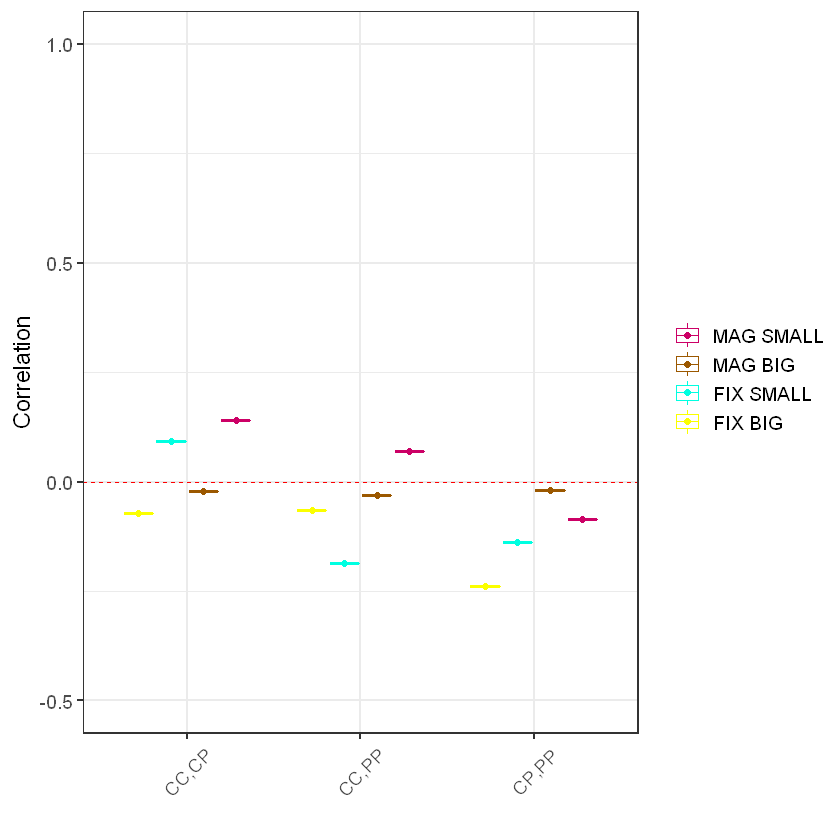

In [124]:
plot.correlations(correlations)
#plot.correlations.reviewer_request(correlations)

#### Do the analysis

In [209]:
h.one.a <- ttestBF(x = FisherZ(correlations$CC_CP),
        mu = FisherZ(0)
       )

In [210]:
h.one.b <- ttestBF(x = FisherZ(correlations$CC_PP),
        mu = FisherZ(0)
       )

In [211]:
h.one.c <- ttestBF(x = FisherZ(correlations$CP_PP),
        mu = FisherZ(0)
       )

### Visualisation of Hypothesis 1 Data

#### Useful functions

In [140]:
# function to perform boundary offsets for beta-distributed data
# suggested by http://doi.apa.org/getdoi.cfm?doi=10.1037/1082-989X.11.1.54
offset.beta <- function(vector, max_val, min_val){
    vector <- (vector-min_val)/(2*max_val) # for normalised trace difference, convert from range [-7,7] to [0,1]
    offset <- (vector * (length(vector)-1) + 0.5) / length(vector) # perform the correction
    return(offset)
}

reverse.offset.beta <- function(vector, max_val, min_val){
    offset.reverse <- 2*vector*max_val+min_val
    return(offset.reverse)
}



In [141]:
# plot some illustrative data
fig5b.trace <- function(df,save=TRUE){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot <- ggplot(plot.df,aes(x=Comparison,y=value,colour=Comparison)) +
        geom_boxplot() +
        guides(colour=guide_legend(title="Stimulus\nSize")) +
        geom_point(position=position_dodge(width=0.75)) +
        ylim(0,7) +
        theme_bw(base_size = 14) +
        guides(color=guide_legend(reverse=TRUE),fill=FALSE) + theme(legend.title=element_blank()) +
        xlab("") +
        scale_y_continuous(name='Mean Identical\n(Normalised Trace)',
                         breaks=c(-1,0,1,2,3,4,5,6,7),
                         labels=c(-1,0,1,2,3,4,5,6,7),
                         limits=c(-1,7)) 
        #scale_colour_brewer(palette='Dark2')
        #scale_colour_manual(values=fix_mag_colours)
    
    
    if(save){
        ggsave('fig5b_trace.png',plot,height=2.8,width=4)
    }
    return(plot)
}

In [142]:
# plot some illustrative data
fig5b.non.trace <- function(df,save=TRUE){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot <- ggplot(plot.df,aes(x=Comparison,y=value,colour=Comparison)) +
        geom_boxplot() +
        guides(colour=guide_legend(title="Stimulus\nSize")) +
        geom_point(position=position_dodge(width=0.75)) +
        ylim(0,7) +
        theme_bw(base_size = 14) +
        guides(color=guide_legend(reverse=TRUE),fill=FALSE) + theme(legend.title=element_blank()) +
        xlab("") +
        scale_y_continuous(name='Mean Non-Identical',
                         breaks=c(-1,0,1,2,3,4,5,6,7),
                         labels=c(-1,0,1,2,3,4,5,6,7),
                         limits=c(-1,7)) 
        #scale_colour_brewer(palette='Dark2')
        #scale_colour_manual(values=fix_mag_colours)
    
    
    if(save){
        ggsave('fig5b_non_trace.png',plot,height=2.8,width=4)
    }
    return(plot)
}

In [143]:
# plot the data
fig5b <- function(df,save=TRUE){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    #plot.df$StimSize <- as.character(plot.df$StimSize)
    #plot.df$Magnification <- as.character(plot.df$Magnification)
    median <- median(subset(plot.df,Comparison=='PP')$value) # for connecting to hypothesis 1b
    
    plot <- ggplot(plot.df,aes(x = Comparison, y = value, 
                         #color = Magnification, 
                         #fill = StimSize
                         colour = label.combo
                                ),
                    size = 0.7) +
        geom_boxplot() +
        guides(colour=guide_legend(title="Stimulus\nSize")) +
        #scale_colour_manual(values = c("red","blue")) + 
        #scale_fill_manual(values = c("#E67E22","#1ABC9C"))
        geom_point(position=position_dodge(width=0.75)) +
        #geom_hline(yintercept=3.5, linetype='dashed') +
        #geom_hline(yintercept=median, linetype = 'dashed',color='blue') +
        ylim(0,7) +
        theme_bw(base_size = 14) +
        guides(color=guide_legend(reverse=TRUE),fill=FALSE) + theme(legend.title=element_blank()) +
        xlab("") +
        #ylab("Normalised Trace") +
        scale_y_continuous(name='Normalised Trace\nDifference',
                         breaks=c(-1,0,1,2,3,4,5,6,7),
                         labels=c(-1,0,1,2,3,4,5,6,7),
                         limits=c(-1,7)) +
        #scale_colour_brewer(palette='Dark2')
        scale_colour_manual(values=fix_mag_colours)
    
    
    if(save){
        ggsave('fig5b.png',plot,height=2.8,width=4)
    }
    return(plot)
}

In [144]:
fig5c <- function(df){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df$value <- (plot.df$value)/max.DSR

    plot <- ggplot(plot.df, aes(x = value, fill=Comparison)) + 
        geom_density(aes(x=value,y=..scaled../3),alpha=0.375) +
        geom_histogram(aes(x=value,y=stat(count)/sum(count)*3), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=0.5, linetype='dashed') +
        xlab("Scaled Normalised Trace Difference") +
        ylab("Density")
        
    ggsave('fig5c.png',plot,height=2.8,width=4)
    return(plot)
}

In [145]:
fig5c.rainbow <- function(df){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df$value <- (plot.df$value)/max.DSR
    
    plot <- ggplot(plot.df,aes(x=Comparison,y=value,fill=Comparison,colour=Comparison)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Comparison)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab('Scaled Normalised Trace') + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=0.5, linetype='dashed') + geom_hline(yintercept=1.05)
    
    ggsave('fig5c_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [146]:
fig5d.rainbow <- function(df){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df$value <- logit(offset.beta(plot.df$value,
                                       max.DSR,
                                       -max.DSR))
    
    #pal <- c('#E67E22','#2ECC71','#B0B901')
    
    plot <- ggplot(plot.df,aes(x=Comparison,y=value,fill=Comparison,colour=Comparison)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Comparison)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab('Logistic-Transformed\nNormalised Trace Difference') + xlab('')+coord_flip()+theme_cowplot()+
            guides(color=guide_legend(reverse=TRUE),fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=logit(0.5), linetype='dashed') + ylim(-2.5,2.5)# +
            #scale_fill_manual(values=pal) + scale_colour_manual(values=pal)
    
    ggsave('fig5d_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [147]:
fig5f.PP.rainbow <- function(df){
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df <- subset(plot.df, Comparison == 'PP') # only keeping PP data
    plot.df$value <- logit(offset.beta(plot.df$value,
                                       max.DSR,
                                       -max.DSR))
        
    plot <- ggplot(plot.df,aes(x=label.combo,y=value,fill=label.combo,colour=label.combo)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(label.combo)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            xlab('')+coord_flip()+theme_cowplot()+
            guides(color=guide_legend(reverse=TRUE),fill=FALSE) +
            geom_hline(yintercept=logit(0.5), linetype='dashed') +
            ylab("Logistic-Transformed\nNormalised Trace Difference") + 
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            ylim(-2.5,2.5)  +
            #scale_fill_brewer(palette='Dark2') + scale_colour_brewer(palette='Dark2')
            scale_fill_manual(values=fix_mag_colours) + scale_colour_manual(values=fix_mag_colours)
    
    ggsave('fig5f_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [148]:
fig5f.CP.rainbow <- function(df){
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df <- subset(plot.df, Comparison == 'CP') # only keeping PP data
    plot.df$value <- logit(offset.beta(plot.df$value,max.DSR))
        
    plot <- ggplot(plot.df,aes(x=label.combo,y=value,fill=label.combo,colour=label.combo)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(label.combo)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            geom_hline(yintercept=logit(0.5), linetype='dashed') +
            ylab("Logistic-Transformed\nNormalised Trace") + 
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            ylim(-7.5,7.5)  +
            scale_fill_brewer(palette='Dark2') + scale_colour_brewer(palette='Dark2')
    
    ggsave('fig5f_rainbow-CP.png',plot,height=2.8,width=4)
    return(plot)
}

#### Do the visualisations

In [151]:
# obtain the data
trace.df <- trace_obtainer(cleandf, type='difference')


In [152]:
# label the data
trace.df <- label(trace.df)

In [153]:
# obtain the relevant data
trace.df.mag <- subset(trace.df, Magnification != 1)
#head(trace.df)

In [155]:
# grab some other peripherally magnified data for illustrative purposes
#identical <- trace_obtainer(subset(cleandf, peripheral_scale != 1), type='trace')
#non.identical <- trace_obtainer(subset(cleandf, peripheral_scale != 1), type='non-trace')

In [156]:
#fig5b.trace(identical)
#fig5b.non.trace(non.identical)

In [158]:
# plot the full data data
#fig5b(trace.df)

In [106]:
#fig5c(trace.df.mag)

In [107]:
#fig5c.rainbow(trace.df.mag)

In [108]:
#fig5d(trace.df.mag)

In [159]:
#fig5d.rainbow(trace.df.mag)

In [89]:
#fig5e(trace.df)

In [90]:
#fig5e.rainbow(trace.df)

In [91]:
#fig5f(trace.df)

In [160]:
#fig5f.CP.rainbow(trace.df)
#fig5f.PP.rainbow(trace.df)

#### 1a) Do subjects respond that identical stimuli have zero dissimilarity when presented at each of CC, CP and PP?

In [162]:
# Determine thresholds

# Mean dissimplarity value across the population, excluding identical-stimuli comparisons
#threshold_df <- subset(cleandf, (Circle_1 == l2e('Central') & (Circle_2 == l2e('Central') ) & (Color_1 != Color_2)) )
#mean(threshold_df$similarity)



In [238]:
# Function to test hypothesis 1a
h1a <- function(data,summary=FALSE){
    data <- offset.beta(data,max.DSR,-max.DSR)
    df <- as.data.frame(data)
    
    model.test <- stan_betareg(
                formula = data ~ 1,
                data = df,
                iter=10000, # helps to stabilise the estimates
                refresh=0
                )
    
    if(summary){
        print(summary(model.test))
    }else{
           print(model.test)
    }
    HPD <- posterior_interval(model.test, prob = 0.95)
    print(HPD)
    BF <- bayesfactor_parameters(model.test)
    print(BF)
    print(plot(BF, show_intercept=TRUE))
    
    # Converted back to normalised trace
    print("")
    print("Converted back to Normalised Trace")
    intercept <- model.test[[1]][1]
    print(paste('Intercept:',round(reverse.offset.beta(invlogit(intercept),max.DSR,-max.DSR),2)))
    print(paste('HPD:',round(reverse.offset.beta(invlogit(HPD[1,]),max.DSR,-max.DSR),2)))
    return(BF)
}


Model Info:
 function:     stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      data ~ 1
 algorithm:    sampling
 sample:       20000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 2

Estimates:
              mean   sd   10%   50%   90%
(Intercept)  0.1    0.9 -1.0   0.1   1.1 
(phi)        2.1    1.3  0.7   1.8   3.8 

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 0.5    0.3  0.1   0.5   0.9  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
              mcse Rhat n_eff
(Intercept)   0.0  1.0  12244
(phi)         0.0  1.0  12481
mean_PPD      0.0  1.0  16809
log-posterior 0.0  1.0   6357

For each parameter, mcse is Monte Carlo standard error, n_eff is a crude measure of effective sample size, and Rhat is the potential scale reduction factor on split chains (at convergence Rhat=1).
                  2.5%  

Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter   |    BF
-------------------
(Intercept) | 0.308

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Intercept: 0.25"
[1] "HPD: -4.76" "HPD: 4.97" 


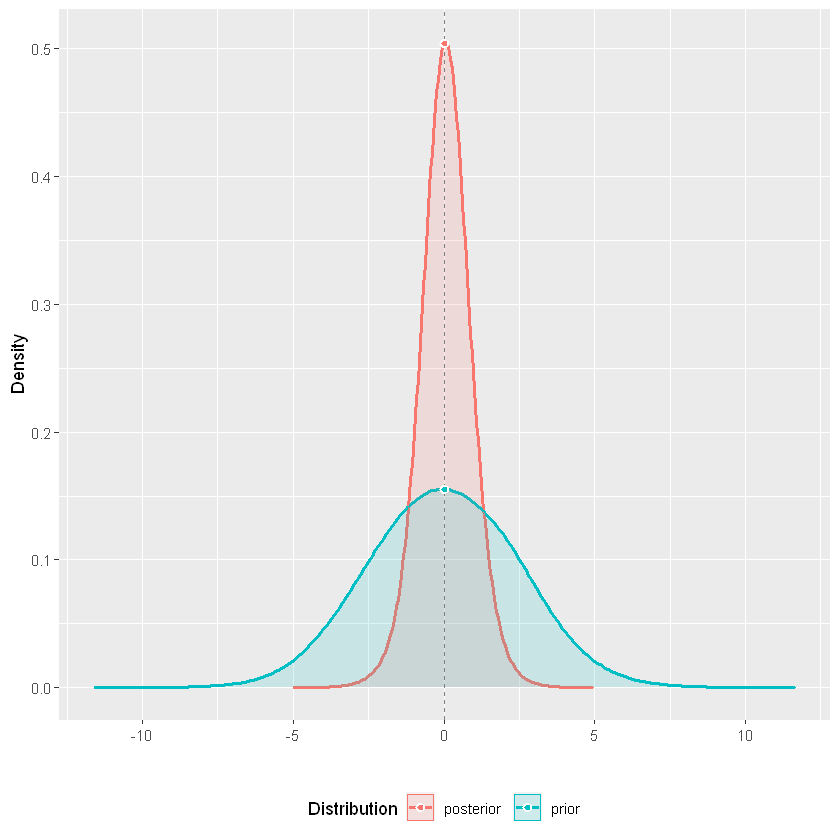

In [239]:
# test CC
h1a.cc <- h1a(trace.df.mag$CC,summary=TRUE)

stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      data ~ 1
 observations: 2
------
            Median MAD_SD
(Intercept) -0.1    0.8  
(phi)        1.8    1.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
                  2.5%    97.5%
(Intercept) -1.7819434 1.690757
(phi)        0.3662727 5.441776


Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter   |    BF
-------------------
(Intercept) | 0.329

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Intercept: -0.18"
[1] "HPD: -4.98" "HPD: 4.82" 


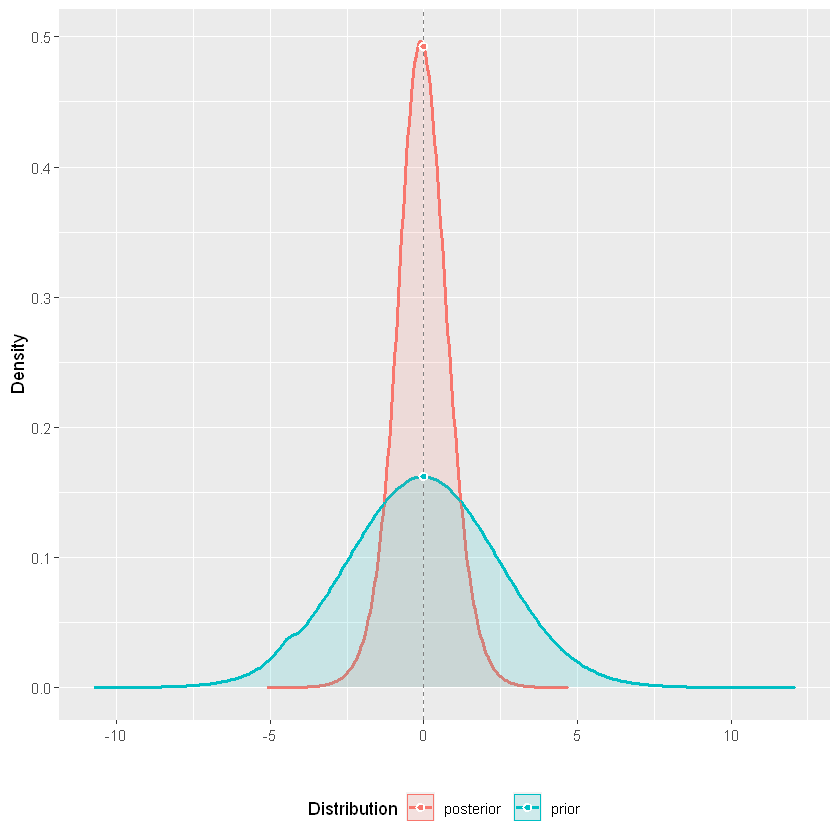

In [244]:
# test CP
h1a.cp <- h1a(trace.df.mag$CP)


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      data ~ 1
 observations: 2
------
            Median MAD_SD
(Intercept) 0.0    0.8   
(phi)       1.8    1.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
                  2.5%    97.5%
(Intercept) -1.6432243 1.784698
(phi)        0.3743308 5.481502


Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter   |    BF
-------------------
(Intercept) | 0.327

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Intercept: 0.15"
[1] "HPD: -4.73" "HPD: 4.99" 


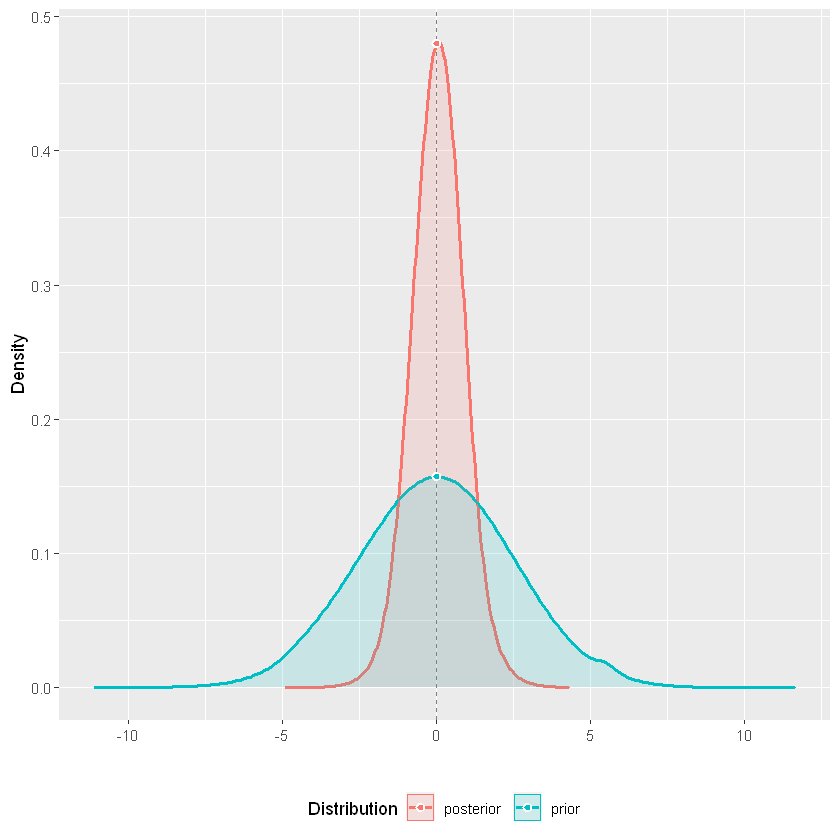

In [245]:
# test PP
h1a.pp <- h1a(trace.df.mag$PP)

#### 1b) Are dissimilarity ratings for identical stimuli presented in the periphery affected by Peripheral magnification?

On the basis of previous psychophysics work we suspect that small stimuli in the periphery may induce altered or unstable colour experiences compared to larger stimuli. We also suspect that appropriately 'cortically magnified' stimuli should provide stable similarity judgments regardless of size. Thus, we hypothesise that there will be a Size x Magnification interaction effect on dissimilarity ratings made in the PP condition.  
  
As we are taking the average over non-negative values with a heavy preponderance of zeros bounded on both sides, the data will be beta-distributed. Thus, we are fitting the data using a Bayesian beta regression.

In [246]:
# Bayesian version of the beta-regression, for sample analysis as well
h1b <- function(data,mode,summary=FALSE){
    
    if(mode=='CP'){
             # normalisation and boundary offset as suggested in Smithson and Verkuilen (2006)
        data$CP <- offset.beta(data$CP,
                               max.DSR,
                              -max.DSR)

        # bayesian stuff
        model.test <- stan_betareg(formula = CP ~ StimSize + Magnification + StimSize:Magnification,
                    data = data,
                    iter=10000, # helps to stabilise the estimates
                    refresh=0
                    )
    } else if(mode=='PP'){
        # normalisation and boundary offset as suggested in Smithson and Verkuilen (2006)
        data$PP <- offset.beta(data$PP,
                               max.DSR,
                              -max.DSR)

        # bayesian stuff
        model.test <- stan_betareg(formula = PP ~ StimSize + Magnification + StimSize:Magnification,
                    data = data,
                    iter=10000, # helps to stabilise the estimates
                    refresh=0
                    )
    }
   
    
    if(summary){
        print(summary(model.test))
    }else{
           print(model.test)
    }
    HPD <- posterior_interval(model.test, prob = 0.95)
    print(HPD)    
    BF <- bayesfactor_parameters(model.test)
    print(BF)
    print(plot(BF, show_intercept=TRUE))
    
    # Converted back to normalised trace
    print("")
    print("Converted back to Normalised Trace")
    interaction <- model.test[[1]][4]
    print(paste('Interaction:',round(reverse.offset.beta(invlogit(interaction),max.DSR,-max.DSR),2)))
    print(paste('HPD:',round(reverse.offset.beta(invlogit(HPD[1,]),max.DSR,-max.DSR),2)))
    
    return(BF)
}


Model Info:
 function:     stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      CP ~ StimSize + Magnification + StimSize:Magnification
 algorithm:    sampling
 sample:       20000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 4

Estimates:
                         mean   sd   10%   50%   90%
(Intercept)             0.0    1.1 -1.4   0.0   1.4 
StimSize               -0.1    1.5 -2.0  -0.1   1.8 
Magnification           0.0    0.1 -0.1   0.0   0.1 
StimSize:Magnification  0.0    0.1 -0.1   0.0   0.1 
(phi)                   2.5    1.3  1.1   2.3   4.3 

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 0.5    0.2  0.3   0.5   0.7  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
                       mcse Rhat n_eff
(Intercept)            0.0  1.0  15130
StimSize               0.0  1.0  12591
Magnification    

Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter              |    BF
------------------------------
(Intercept)            | 0.306
StimSize               | 0.554
Magnification          | 0.564
StimSize:Magnification | 0.415

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Interaction: 0.02"
[1] "HPD: -5.73" "HPD: 5.67" 


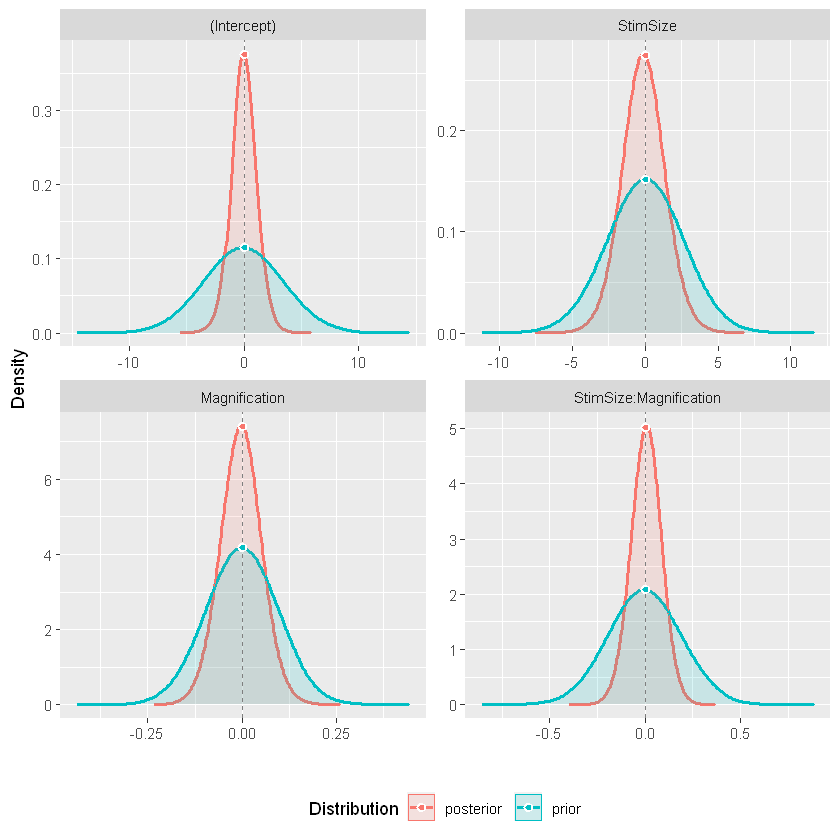

In [247]:
# test all the CP data
h1b.model <- h1b(trace.df, mode='CP',summary=TRUE)


Model Info:
 function:     stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      PP ~ StimSize + Magnification + StimSize:Magnification
 algorithm:    sampling
 sample:       20000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 4

Estimates:
                         mean   sd   10%   50%   90%
(Intercept)             0.1    1.1 -1.3   0.1   1.5 
StimSize               -0.1    1.5 -2.0  -0.1   1.8 
Magnification           0.0    0.1 -0.1   0.0   0.1 
StimSize:Magnification  0.0    0.1 -0.1   0.0   0.1 
(phi)                   2.5    1.3  1.1   2.3   4.3 

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 0.5    0.2  0.3   0.5   0.7  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
                       mcse Rhat n_eff
(Intercept)            0.0  1.0  13803
StimSize               0.0  1.0  11296
Magnification    

Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter              |    BF
------------------------------
(Intercept)            | 0.307
StimSize               | 0.535
Magnification          | 0.563
StimSize:Magnification | 0.408

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Interaction: 0"
[1] "HPD: -5.63" "HPD: 5.8"  


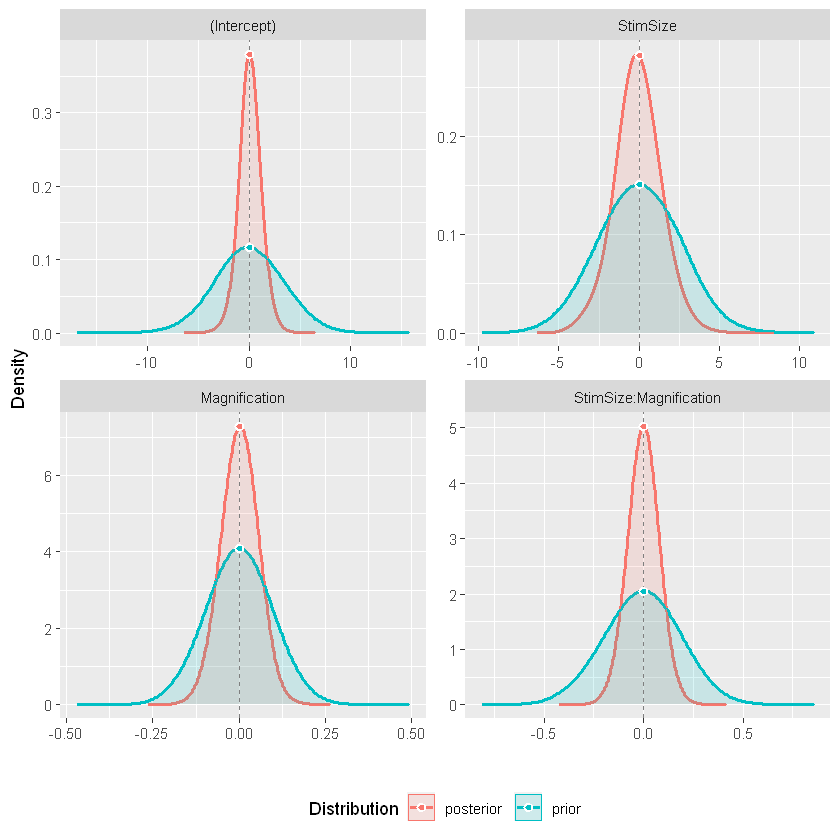

In [170]:
# test all the PP data
h1b.model <- h1b(trace.df, mode='PP',summary=TRUE)

### Visualisation of Hypothesis 2 Data

#### Useful functions

In [171]:
# get the mean variance of colour comparisons for a subject
var.color <- function(df,diagnose=FALSE,sym=sym,mode='raw',repeats=100,output='mean',scramble=FALSE){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(df, l2e('Central'), l2e('Central'),sym=sym)
    fpmatrix <- df2mat.full(df, l2e('Central'), l2e('Peripheral'),sym=sym)
    pmatrix <- df2mat.full(df, l2e('Peripheral'), l2e('Peripheral'),sym=sym)
    
    # for comparison, option to shuffle CP & PP
    if(scramble){
        fpmatrix <- matrix(sample(fpmatrix),nrow=nrow(fpmatrix))
        pmatrix <- matrix(sample(pmatrix),nrow=nrow(pmatrix))
    }
    
    # calculate the variance for each colour
    colour.vars <- vector()
    # calculate differently based on whether data is symmeterised or not
    if(sym){ # symmeterised
        
        
        # turn the matrices into vectors
        ff.v <- fmatrix[upper.tri(fmatrix,diag=TRUE)]
        fp.v <- fpmatrix[upper.tri(fpmatrix,diag=TRUE)]
        pp.v <- pmatrix[upper.tri(pmatrix,diag=TRUE)]
        
        for(i in 1:length(ff.v)){
            colour.vars[i] <- var(c(ff.v[i],fp.v[i],pp.v[i]))
        }
    } else { # raw, unsymmeterised
        i = 1
        
        # remove the main diagonal
        diag(fmatrix) = NA
        diag(fpmatrix) = NA
        diag(pmatrix) = NA
        
        # collect the entries
        ff.upper.v <- vector()
        fp.upper.v <- vector()
        pp.upper.v <- vector()
        ff.lower.v <- vector()
        fp.lower.v <- vector()
        pp.lower.v <- vector()
        for(row in 1:(nrow(fmatrix))){
            for(col in 1:(ncol(fmatrix))){
                if(row < col){ # I am aware this is wasteful, but it's easy
                    ff.upper.v[i] <- fmatrix[row,col]
                    fp.upper.v[i] <- fpmatrix[row,col]
                    pp.upper.v[i] <- pmatrix[row,col]
                    
                    ff.lower.v[i] <- fmatrix[col,row]
                    fp.lower.v[i] <- fpmatrix[col,row]
                    pp.lower.v[i] <- pmatrix[col,row]
                    
                    i = i + 1
                } 
            }
        }
        
        # remove NA values
        ff.upper.v <- na.omit(ff.upper.v)
        fp.upper.v <- na.omit(fp.upper.v)
        pp.upper.v <- na.omit(pp.upper.v)
        ff.lower.v <- na.omit(ff.lower.v)
        fp.lower.v <- na.omit(fp.lower.v)
        pp.lower.v <- na.omit(pp.lower.v)
        
        if(diagnose){
            print("upper")
            print(ff.upper.v)
            print(length(ff.upper.v))
            print("lower")
            print(ff.lower.v)
            print(length(ff.lower.v))
        }
        
        for(i in 1:length(ff.upper.v)){
            vals <- c(ff.upper.v[i],ff.lower.v[i],
                         fp.upper.v[i],fp.lower.v[i],
                         pp.upper.v[i],pp.lower.v[i])
            colour.vars[i] <- var(vals) # calculate variance of the colour pair judgments
        }
        
    }
    
    
    if(diagnose){
        print("Variance values")
        print(colour.vars)
    }
    
    
    # get the mean variance
    var.mean <- mean(colour.vars) # take the mean of all the colour pairs
    
    # if mode = scramble, calculate the difference between the observed variance and that if the
    # colour-pair/judgment labels were scrambled
    
    # if no scrambling, just return mean variance
    if(output=='distribution'){
        # return the distribution of variance values for each subject
        return(colour.vars)
    }else if(output=='mean'){
        return(var.mean)
    }
}

In [172]:
# shuffled variance - real variance
shuffle.vs.real <- function(df,n_scramble=5,sym=sym,mode=mode,output='mean'){
    real <- var.color(df, sym=sym, output=output,mode=mode)
    v <- vector()
    for(i in 1:n_scramble){
        v <- c(v, mean(var.color(df, sym=FALSE, output='distribution',mode='raw',scramble=TRUE)))
    }
    return(mean(v)-real)
}

In [173]:
# simple histogram plot of the variance for a subject
var.hist.plot <- function(dat){
    df <- as.data.frame(dat)
    #print(df)
    plot <- ggplot(df,aes(x=dat)) + geom_histogram()   + ylim(0,36) + #xlim(-1,10) +
        geom_vline(xintercept=mean(dat),linetype='dashed',color='purple',size=2) +
        #geom_vline(xintercept=0,linetype='dashed',color='red',size=2) +
        #geom_vline(xintercept=rand.var.mu-mean(dat),linetype='dashed',color='blue',size=2)
        theme(text=element_text(size=50)) + scale_x_continuous(breaks=seq(0,10,5), limits = c(-1,11))
    return(plot)
}

#var.hist.plot(test.data)

In [186]:
# get the data in the right format
var.format <- function(df,n_shuffle=5,sym=FALSE,mode='raw'){
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    
    if(sym){
            print('Working on symmeterised (3) values')
        } else {
            print('Working on raw (6) values')
        }
    
    # format for output
    out.df <- data.frame(subject=character(),
                        mean.var=double(),
                        stim_size=double(),
                        magnification=double())
    # extract the data
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_size))
    for(ID in subjectlist){
        #print(ID) # testing
        tempdf <- subset(df, subject == ID)
        for (stimulus in size_list){
            for (scale in magnification_list){
                tempdf2 <- subset(tempdf, peripheral_scale == scale & stimulus_size == stimulus)
                stim <- unique(tempdf2$stimulus_size)[1]
                mag <- unique(tempdf2$peripheral_scale)[1]
                val <- shuffle.vs.real(tempdf2,sym=sym,mode=mode) # collect the variance
                row_df <- data.frame(ID, val, stim, mag)
                names(row_df) <- c("subject",'mean.var','StimSize','Magnification')
                out.df <- rbind(out.df,row_df)
            }
        }
    }
    return(out.df)
}

In [175]:
# calculate the mean variance for each color for plotting purposes
fig6bc <- function(df,name,tri=TRUE){
    # convert the data
    mats <- dissimgroup2matlist(df,sym=TRUE)
    mats.var <- full2var.mats(mats)
    mat <- group.mat.median(mats.var)
    
    # get rid of the lower half
    if(tri){
        mat[lower.tri(mat)] <- NA
    }
    
    
    data <- melt(mat)
    colnames(data) <- c('color1.eccen1','color2.eccen2','Variance')
    
    plot <- ggplot(data, aes(x = color1.eccen1, y = color2.eccen2)) + 
                    geom_raster(aes(fill = Variance)) +
                    scale_fill_gradientn(colours = c("blue","yellow"),
                                    limits=c(0,6), na.value='white'
                                    #breaks=c(0,1,2,3,4,5,6,7)
                                        ) +
                    # colours
                   theme(axis.text.x = element_text(colour=colors,angle=90),
                          axis.text.y = element_text(colour=colors),
                          axis.title.x = element_blank(), axis.title.y = element_blank(),
                          plot.title = element_text(hjust = 0.5)) +
                    scale_colour_identity()
    
    ggsave(name,plot,height=2.8,width=3.75)
    return(plot)
}

In [176]:
fig6d <- function(plot.df,rand.var.mu,histogram=FALSE,save=TRUE){
    
    plot.df$StimSize <- as.character(plot.df$StimSize)
    plot.df$Magnification <- as.character(plot.df$Magnification)
    
    plot <- ggplot(plot.df) +
        geom_boxplot(aes(x = Magnification, y = mean.var, 
                         color = label.combo)) +
        geom_point(aes(x = Magnification, y = mean.var, 
                         color = label.combo),
                  position=position_dodge(width=0.75)) +
        #geom_hline(yintercept=rand.var.mu, linetype='dashed') +
        #geom_hline(yintercept=median(plot.df$mean.var),linetype='dashed',color='blue') +
        scale_x_discrete(labels=c("FIX",'MAG')) +
        theme_bw(base_size = 14) +
        #guides(color=guide_legend(title="Stimulus\nSize")) +
        guides(color=guide_legend(title="")) +
        xlab("") +
        ylab("Mean Variance (Scrambled)\n- Mean Variance (Real)") +
        #ylim(min(plotdf$mean.var),max(vals)) +
        #scale_colour_manual(values = c("orange",'purple')) +
        #scale_color_brewer(palette='Dark2') + scale_fill_brewer(palette='Dark2')
        scale_fill_manual(values=fix_mag_colours) + scale_colour_manual(values=fix_mag_colours) +
        guides(color=guide_legend(reverse=TRUE),fill=FALSE) + theme(legend.title=element_blank())
    if(histogram){
        #plot.df$mean.var <- log((plot.df$mean.var))
        plot.df$label.combo <- paste(plot.df$StimSize,plot.df$Magnification)
        hist.plot <- ggplot(plot.df, aes(x = mean.var, fill=label.combo)) + geom_histogram(binwidth=0.25)
        return(hist.plot)
    }
    if(save){
        ggsave('fig6d.png',plot,height=3,width=4)
    }
    
    return(plot)
}

In [177]:
fig6e <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- offset.beta(df$mean.var,
                               max(vals),
                              min(vals))

    plot <- ggplot(df, aes(x = mean.var,fill=Magnification)) + 
        geom_density(aes(x=mean.var,y=..scaled..),alpha=0.375) +
        geom_histogram(aes(x=mean.var,y=stat(count)/sum(count)), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=rand.var.mu/max(vals), linetype='dashed') + # put the random line in, appropriately scaled
        xlab("Scaled Mean Variance") +
        ylab("Density") +
        xlim(-0.05,1) +
        theme(legend.position='none')
        
    ggsave('fig6e.png',plot,height=2.8,width=4)
    return(plot)
} 

In [178]:
fig6e.rainbow <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- offset.beta(df$mean.var,
                               max(vals),
                              min(vals))
    
    plot <- ggplot(df,aes(x=Magnification,y=mean.var,fill=Magnification,colour=Magnification)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=4.5 + 0.25, y = mean.var),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab('Scaled Mean Variance') + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=rand.var.mu/max(vals), linetype='dashed') +  geom_hline(yintercept=1.05)
    
    ggsave('fig6e_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [179]:
fig6f <- function(df,rand.var.mu,vals){
    # perform beta offset
    df$mean.var <- logit(offset.beta(df$mean.var,
                                     max(vals),
                                    min(vals)))

    plot <- ggplot(df, aes(x = mean.var,fill=Magnification)) + 
        geom_density(aes(x=mean.var,y=..scaled..),alpha=0.375) +
        #geom_histogram(aes(x=mean.var,y=stat(count)/sum(count)), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=logit(rand.var.mu/max(vals)), linetype='dashed') + # put the random line in, appropriately scaled
        xlab("Logistic-Transformed\nMean Variance") +
        ylab("Density") +
        xlim(-7.5,3) +
        theme(legend.position='none')
        
    ggsave('fig6f.png',plot,height=2.8,width=4)
    return(plot)
}

In [180]:
fig6f.rainbow <- function(df,vals){
    
    
    # perform beta offset
    df$mean.var <- logit(offset.beta(df$mean.var,
                                     max(vals),
                                    -max(vals)))
    
    
    plot <- ggplot(df,aes(x=Magnification,y=mean.var,fill=Magnification,colour=Magnification)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=4.5 + 0.25, y = mean.var),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            ylab("Logistic-Transformed\nMean Variance (Scrambled) -\n Mean Variance (Real)") +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=logit(0), linetype='dashed') # altered to zero
    
    ggsave('fig6f_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [181]:
fig6g <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- offset.beta(df$mean.var,
                               max(vals),
                              min(vals))

    plot <- ggplot(df, aes(x = mean.var,fill=label.combo)) + 
        geom_density(aes(x=mean.var,y=..scaled..),alpha=0.375) +
        geom_histogram(aes(x=mean.var,y=stat(count)/sum(count)), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=rand.var.mu/max(vals), linetype='dashed') + # put the random line in, appropriately scaled
        xlab("Scaled Mean Variance") +
        ylab("Density") +
        xlim(-0.05,1)
        
    ggsave('fig6g.png',plot,height=2.8,width=4)
    return(plot)
} 

In [182]:
fig6g.rainbow <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- offset.beta(df$mean.var,
                               max(vals),
                              min(vals))
    
    plot <- ggplot(df,aes(x=label.combo,y=mean.var,fill=label.combo,colour=label.combo)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(label.combo)) + 0.25, y = mean.var),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab('Scaled Mean Variance') + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=rand.var.mu/max(vals), linetype='dashed') +  geom_hline(yintercept=1.05)
    
    ggsave('fig6g_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [183]:
fig6h <- function(df,rand.var.mu,vals){
    # perform beta offset
    df$mean.var <- logit(offset.beta(df$mean.var,
                                     max(vals),
                                    min(vals)))

    plot <- ggplot(df, aes(x = mean.var,fill=label.combo)) + 
        geom_density(aes(x=mean.var,y=..scaled..),alpha=0.375) +
        #geom_histogram(aes(x=mean.var,y=stat(count)/sum(count)), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=logit(rand.var.mu/max(vals)), linetype='dashed') + # put the random line in, appropriately scaled
        xlab("Logistic-Transformed\nMean Variance") +
        ylab("Density") +
        xlim(-7.5,3)
        
    ggsave('fig6h.png',plot,height=2.8,width=4)
    return(plot)
}

In [184]:
fig6h.rainbow <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- logit(offset.beta(df$mean.var,
                                     max(vals),
                                    min(vals)))
    
    plot <- ggplot(df,aes(x=label.combo,y=mean.var,fill=label.combo,colour=label.combo)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(label.combo)) + 0.25, y = mean.var),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Logistic-Transformed\nMean Variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=logit(rand.var.mu/max(vals)), linetype='dashed') +
            scale_color_brewer(palette='Dark2') + scale_fill_brewer(palette='Dark2')
    
    ggsave('fig6h_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

#### Do the visualisations

In [187]:
# get the data we want
var.data <- var.format(cleandf,sym=FALSE)
#var.data <- var.format(cleandf,sym=FALSE,mode='scrambled')
#head(var.data)
var.data.mag <- subset(var.data, Magnification != 1)


[1] "Working on raw (6) values"


In [188]:
# label the data
var.data <- label(var.data)

In [189]:
# supply empirical data for random selection simulation below
sim.rand.var.empirical <- function(df,mode){
    if(mode=='CC'){
        temp_df <- subset(df, (Circle_1 == l2e('Central')) & (Circle_2 == l2e('Central')) ) 
    } else if(mode == 'CP'){
        temp_df <- subset(df, (Circle_1 == l2e('Central')) & (Circle_2 == l2e('Peripheral')) )
    } else if(mode == 'PC'){
        temp_df <- subset(df, (Circle_1 == l2e('Peripheral')) & (Circle_2 == l2e('Central')) )
    } else if (mode=='PP'){
        temp_df <- subset(df, (Circle_1 == l2e('Peripheral')) & (Circle_2 == l2e('Peripheral')) )
    } else {
        temp_df <- df
    }
    return(temp_df$similarity)
}

In [191]:
# simulating random selection
# updated method based on including symmeterisation
sim.rand.var <- function(method='sym',mode='empirical'){
    dis.v <- c(0:7)
    if(method=='sym'){
        # taking the mean of the values as expected by symmeterisation procedure
        # this is more faithful to what random data fed into the preprocessing 
        # procedure would look like
        vals <- vector()
        if(mode=='empirical'){
            CC.data <- sim.rand.var.empirical(cleandf,mode='CC')
            CP.data <- sim.rand.var.empirical(cleandf,mode='CP')
            PC.data <- sim.rand.var.empirical(cleandf,mode='PC')
            PP.data <- sim.rand.var.empirical(cleandf,mode='PP')
        }
        for(i in 1:10000){
            if(mode=='empirical'){
                CC <- mean(sample(CC.data, 2, replace=TRUE))
                CP <- mean(sample(CP.data, 2, replace=TRUE))
                PC <- mean(sample(PC.data, 2, replace=TRUE))
                PP <- mean(sample(PP.data, 2, replace=TRUE)) 
            } else{
                CC <- mean(sample(dis.v, 2, replace=TRUE))
                CP <- mean(sample(dis.v, 2, replace=TRUE))
                PC <- mean(sample(dis.v, 2, replace=TRUE))
                PP <- mean(sample(dis.v, 2, replace=TRUE))  
            }
            
            CP.sym <- mean(c(CP,PC))
                        
            x <- var(c(CC,PP,CP.sym))
            
            
            vals <- c(vals,x)
            
        }
        
        
    } else {
        # pick n random dissimilarity values
        # 3 = equivalent to 1 CC, 1 PP and 1 CP values
        # 6 = equivalent to 2 CC, 2 PP and 2 CP values
        # 8 = equivalent to 2 CC, 2 PP and 4 CP values
        if(mode=='empirical'){
            dis.v <- sim.rand.var.empirical(cleandf,mode='all')
        }
        vals <- replicate(10000,var(sample(dis.v, method, replace=TRUE)))
    }
    print(paste("Mean variance of random selection:",mean(vals)))
    print(paste("SD of mean variance of random selection:",sd(vals)))
    return(vals)
}
#vals <- sim.rand.var()
#vals <- sim.rand.var(method=3)
#vals <- sim.rand.var(method=6)
#vals <- sim.rand.var(method=8)
#vals <- sim.rand.var(method=6,mode='empirical')

#rand.var.mu <- mean(vals)
#rand.var.sd <- sd(vals)

In [192]:
# supplementary figure of how random selection variance is distributed
sup.fig5a <- function(vals){
    mu <- mean(vals)
    df <- as.data.frame(vals)
    df$Variance <- 'Variance'
    plot <- ggplot(df, aes(x=vals,y=..density..)) + geom_histogram(binwidth=1/3,colour='black') + #geom_density(aes(fill=Variance),alpha=0.3) +
        geom_vline(xintercept=mu,linetype='dashed') + guides(fill=FALSE) +
        xlab("Variance") + ylab("Proportion")
    ggsave('supfig5a.png',plot,height=4,width=5.3)
    return(plot)
}

sup.fig5b <- function(vals){
    mu <- mean(vals)
    df <- as.data.frame(vals)
    df$Variance <- 'Variance'
    df$vals <- offset.beta(df$vals,max(vals))
    
    plot.scaled <- ggplot(df,aes(x=Variance,y=vals,fill=Variance,colour=Variance)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Variance))+ 0.25, y = vals),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Scaled variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=mu, linetype='dashed') + ylim(0,1)
    
    ggsave('supfig5b.png',plot.scaled,height=4,width=5.3)
    return(plot.scaled)
}

sup.fig5c <- function(vals){
    mu <- mean(vals)
    df <- as.data.frame(vals)
    df$Variance <- 'Variance'
    df$vals <- offset.beta(df$vals,max(vals))
    df$vals.logit <- logit(df$vals)
    mu.logit <- logit(mu)

    plot.logit <- ggplot(df,aes(x=Variance,y=vals.logit,fill=Variance,colour=Variance)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Variance))+ 0.25, y = vals.logit),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Logistic-transformed variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=mu.logit, linetype='dashed')
    
    ggsave('supfig5c.png',plot.logit,height=4,width=5.3)
    return(plot.logit)
}



In [193]:
#sup.fig5a(vals)
#sup.fig5b(vals)
#sup.fig5c(vals)

In [195]:
sup.fig5.raincloud <- function(vals){
    mu <- mean(vals)
    df <- as.data.frame(vals)
    df$Variance <- 'Variance'
    df$vals <- offset.beta(df$vals,max(vals))
    df$vals.logit <- logit(df$vals)
    mu.logit <- logit(mu)
    
    plot.scaled <- ggplot(df,aes(x=Variance,y=vals,fill=Variance,colour=Variance)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Variance))+ 0.25, y = vals),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Scaled variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=mu, linetype='dashed') + ylim(0,1)
    

    plot.logit <- ggplot(df,aes(x=Variance,y=vals.logit,fill=Variance,colour=Variance)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Variance))+ 0.25, y = vals.logit),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Logistic-transformed variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=mu.logit, linetype='dashed')
    
    g <- arrangeGrob(as.grob(plot.scaled),as.grob(plot.logit),ncol=1,nrow=2)
    ggsave('supfig5_raincloud.png',g,height=8,width=5.3)
}
#sup.fig5.raincloud(vals)

In [196]:
mag.df <- subset(cleandf, peripheral_scale != 1)
#fig6bc(mag.df,name='fig6c.png',tri=TRUE)

In [198]:
#fig6d(var.data,rand.var.mu)

In [199]:
#fig6e(var.data.mag,rand.var.mu,vals)
#fig6e.rainbow(var.data.mag,rand.var.mu,vals)

In [200]:
#fig6f(var.data.mag,rand.var.mu,vals)
#fig6f.rainbow(var.data.mag,vals)

In [201]:
#fig6g(var.data,rand.var.mu,vals)
#fig6g.rainbow(var.data,rand.var.mu,vals)

In [202]:
#fig6h(var.data,rand.var.mu,vals)
#fig6h.rainbow(var.data,rand.var.mu,vals)

#### 2a) Do colour-pair comparisons made in CC, CP and PP conditions all generate the same dissimilarity ratings?

Going beyond whether identical physical stimuli elicit zero dissimilarity, we want to know whether the same pair of colours elicits the same dissimilarity value for a given subject whether it's presented in a CC, CP or PP condition.  
  
For each colour comparison a subject makes (e.g. RED-BLUE), we will calculate the variance between their CC, CP and PP responses. We will then take the mean variance across all of these colour comparisons for a given subject and use that as a measure of consistency.  
  
If subjects are choosing randomly, we'd expect them to have a mean variance of three randomly selected values from 0-7, which is ~5.25 (as calculated numerically below).  
  
We will test to see if the mean variance for each subject is less than 5.25 in data from subjects in the Peripherally magnified conditions. As the data is once again bounded we will use a beta-regression again.

In [259]:
h2a <- function(data,vals,summary=FALSE){
    data$mean.var <- offset.beta(data$mean.var,
                                 max(vals),
                                -max(vals))
    
    model.test <- stan_betareg(formula = mean.var ~ 1,
                              data = data,
                              iter=10000, # stabilise the estimates
                               refresh=0
                            )
    
    if(summary){
        print(summary(model.test))
    }else{
           print(model.test)
    }
    HPD <- posterior_interval(model.test, prob = 0.95)
    print(HPD)    
    BF <- bayesfactor_parameters(model.test)
    print(BF)
    print(plot(BF, show_intercept=TRUE))
    
    # Converted back to normalised trace
    print("")
    print("Converted back to Mean Variance")
    intercept <- model.test[[1]][1]
    print(paste('Intercept:',round(reverse.offset.beta(invlogit(intercept),max(vals),-max(vals)),2)))
    print(paste('HPD:',round(reverse.offset.beta(invlogit(HPD[1,]),max(vals),-max(vals)),2)))
    
    return(BF)
}

stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      mean.var ~ 1
 observations: 2
------
            Median MAD_SD
(Intercept) 0.0    0.8   
(phi)       1.8    1.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
                  2.5%    97.5%
(Intercept) -1.7118838 1.715122
(phi)        0.3774721 5.466606


Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter   |    BF
-------------------
(Intercept) | 0.307

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Mean Variance"
[1] "Intercept: -0.05"
[1] "HPD: -10.2" "HPD: 10.22"


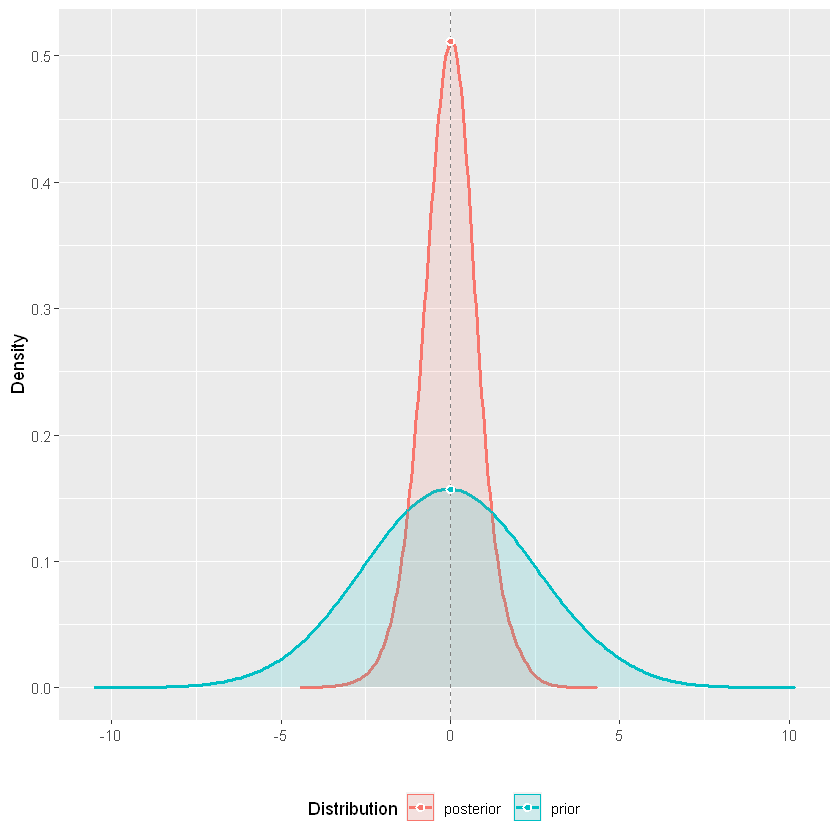

In [260]:
# test all the Peripheral magnification data
h3 <- h2a(var.data.mag,vals)

#### 2b) Are dissimilarity ratings for colour-pairs presented in the periphery affected by Peripheral magnification?

Blah

In [207]:
h2b <- function(data,summary=FALSE){
    data$mean.var <- offset.beta(data$mean.var,
                                 max(vals),
                                -max(vals))
    
    model.test <- stan_betareg(formula = mean.var ~ StimSize + Magnification + StimSize:Magnification,
                data = data,
                iter=10000, # helps to stabilise the estimates
                refresh=0 # removes verbose output
                )
    
    if(summary){
        print(summary(model.test))
    }else{
           print(model.test)
    }
    HPD <- posterior_interval(model.test, prob = 0.95)
    print(HPD)    
    BF <- bayesfactor_parameters(model.test)
    print(BF)
    print(plot(BF, show_intercept=TRUE))
    
    # Converted back to normalised trace
    print("")
    print("Converted back to Mean Variance")
    interaction <- model.test[[1]][4]
    print(paste('Interaction:',round(reverse.offset.beta(invlogit(interaction),max(vals),-max(vals)),2)))
    print(paste('HPD:',round(reverse.offset.beta(invlogit(HPD[1,]),max(vals),-max(vals)),2)))
    
    return(model.test)
}

stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      mean.var ~ StimSize + Magnification + StimSize:Magnification
 observations: 4
------
                       Median MAD_SD
(Intercept)            0.0    1.1   
StimSize               0.0    1.4   
Magnification          0.0    0.1   
StimSize:Magnification 0.0    0.1   
(phi)                  2.3    1.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
                             2.5%     97.5%
(Intercept)            -2.3380791 2.2884585
StimSize               -2.9684766 2.9394135
Magnification          -0.1104010 0.1118244
StimSize:Magnification -0.1627323 0.1599619
(phi)                   0.7057766 5.7695012


Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter              |    BF
------------------------------
(Intercept)            | 0.317
StimSize               | 0.554
Magnification          | 0.569
StimSize:Magnification | 0.421

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Mean Variance"
[1] "Interaction: 0"
[1] "HPD: -12.11" "HPD: 11.99" 


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      mean.var ~ StimSize + Magnification + StimSize:Magnification
 observations: 4
------
                       Median MAD_SD
(Intercept)            0.0    1.1   
StimSize               0.0    1.4   
Magnification          0.0    0.1   
StimSize:Magnification 0.0    0.1   
(phi)                  2.3    1.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

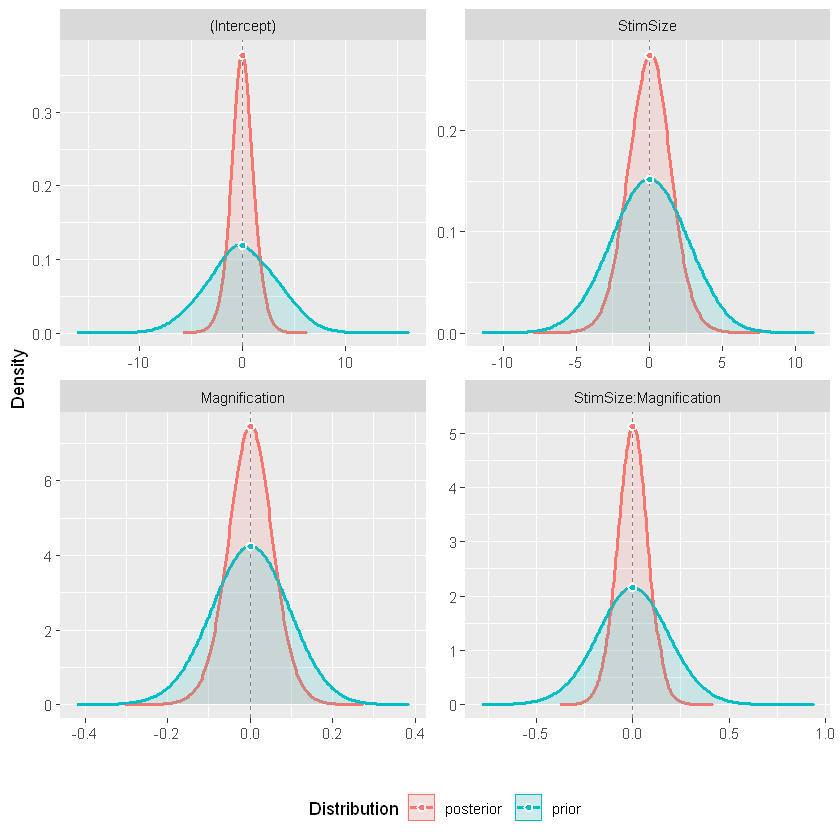

In [208]:
# test all the data
h2b(var.data)

## Collect it all into one table/plot for Yasunori

In [296]:
BF.table <- function(){
    
    #subject count
    subj_n <- get_n(cleandf,print=FALSE)
    
    #H1A
    h1a.bf <- exp(h.one.a@bayesFactor$bf)
    #print(h1a.bf)
    #H1B
    h1b.bf <- exp(h.one.b@bayesFactor$bf)
    #print(h1b.bf)
    #H1C
    h1c.bf <- exp(h.one.c@bayesFactor$bf)
    #print(h1c.bf)
    
    #H2A
    h2a.bf <- exp(h1a.cc$log_BF)
    #print(h2a.bf)
    #H2B
    h2b.bf <- exp(h1a.cp$log_BF)
    #print(h2b.bf)
    #H2C
    h2c.bf <- exp(h1a.pp$log_BF)
    #print(h2c.bf)
    
    #H2D
    h2d.bf <- exp(h1b.model$log_BF[4])
    
    #H3
    h3.bf <- exp(h3$log_BF)
    
    BFs <- c(h1a.bf,h1b.bf,h1c.bf,
             h2a.bf,h2b.bf,h2c.bf,
             h2d.bf,
             h3.bf)
    
    Names <- c('H1A','H1B','H1C',
              'H2A','H2B','H2C',
              'H2D',
              'H3')
    bf.df <- data.frame(Names,BFs)
    
    bf.df$Finished <- 'NO'
    bf.df$Finished[bf.df$BFs < 0.1] <- 'YES'
    bf.df$Finished[bf.df$BFs > 10] <- 'YES'
    
    return(bf.df)
}

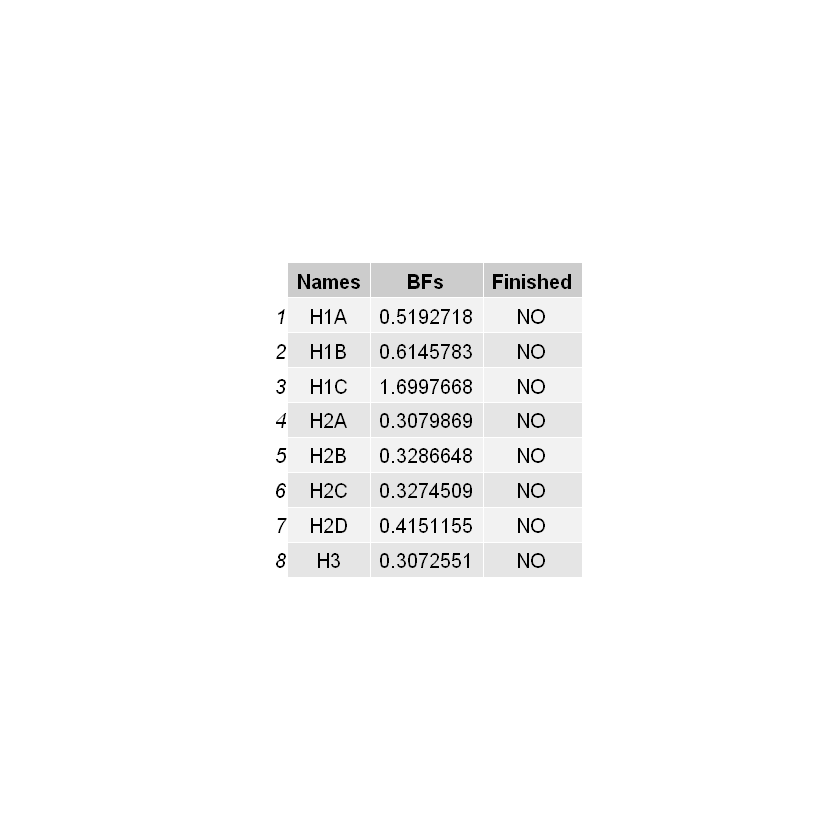

In [298]:
grid.table(BF.table())